## Diabetes related deaths

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

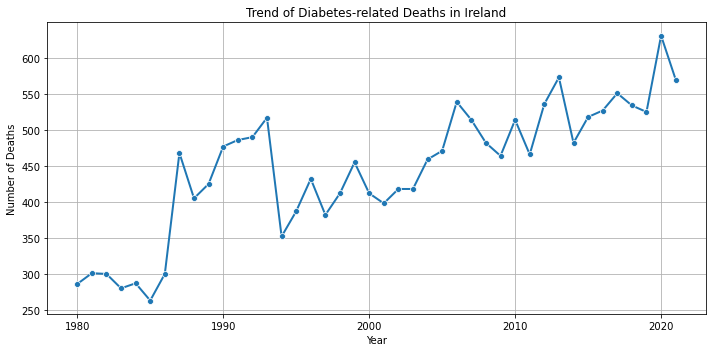

In [3]:
df = pd.read_csv("Final\Deaths.csv")
diabetes_death = df[
    (df['Cause of Death'].str.contains("Diabetes mellitus", case=False, na=False)) &
    (df['Statistic Label'] == 'Deaths') &
    (df['Area'] != 'All counties and regions')
].reset_index(drop=True)


# Remove rows where Sex is 'Both sexes'
diabetes_filtered = diabetes_death[diabetes_death['Sex'] != 'Both sexes']

# group by Year and sum values
trend = diabetes_filtered.groupby("Year")["VALUE"].sum().reset_index()

plt.figure(figsize=(10, 5))
sns.lineplot(data=trend, x="Year", y="VALUE", marker="o", linewidth=2)
plt.title("Trend of Diabetes-related Deaths in Ireland")
plt.xlabel("Year")
plt.ylabel("Number of Deaths")
plt.grid(True)
plt.tight_layout()
plt.show()

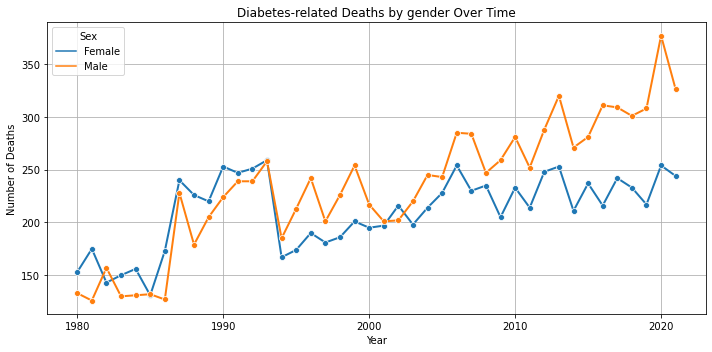

In [3]:
# Group by Year and Sex, summing the death counts
sex_trend = diabetes_filtered.groupby(["Year", "Sex"])["VALUE"].sum().reset_index()

# Plot
plt.figure(figsize=(10, 5))
sns.lineplot(data=sex_trend, x="Year", y="VALUE", hue="Sex", marker="o", linewidth=2)
plt.title("Diabetes-related Deaths by gender Over Time")
plt.xlabel("Year")
plt.ylabel("Number of Deaths")
plt.grid(True)
plt.tight_layout()
plt.show()

## Diabetes related deaths county wise

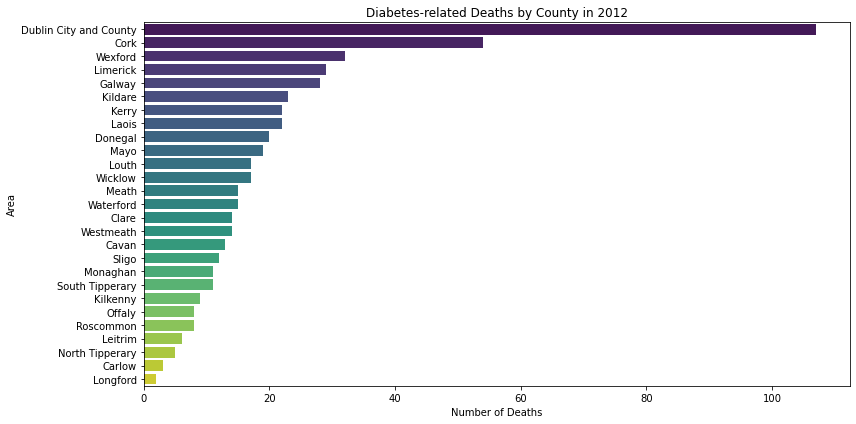

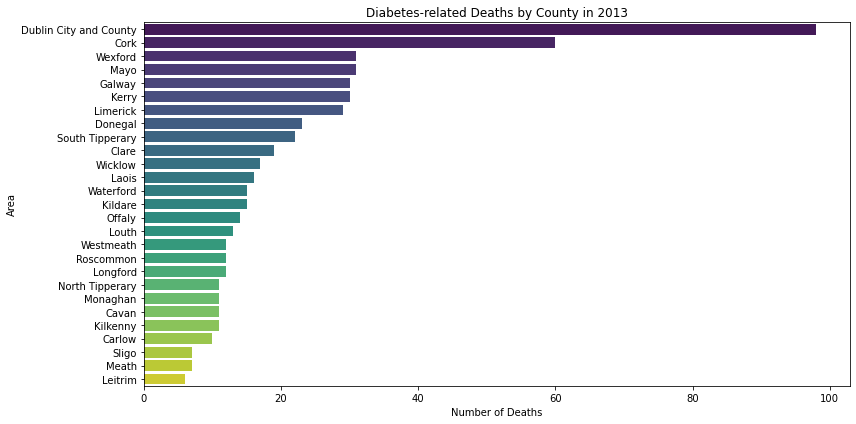

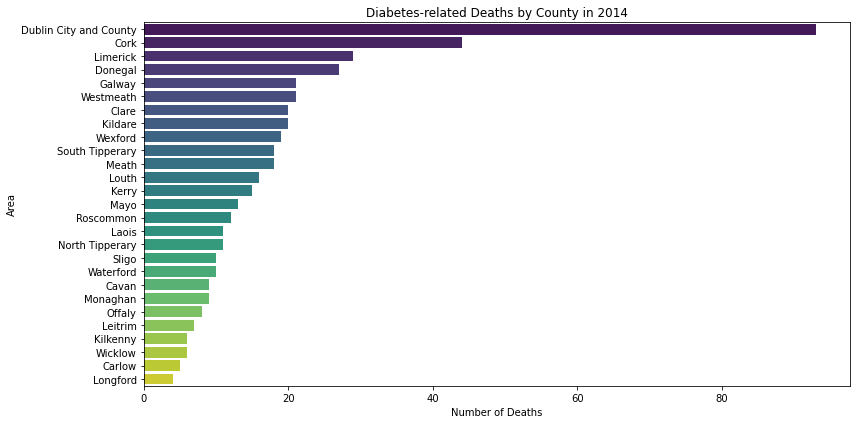

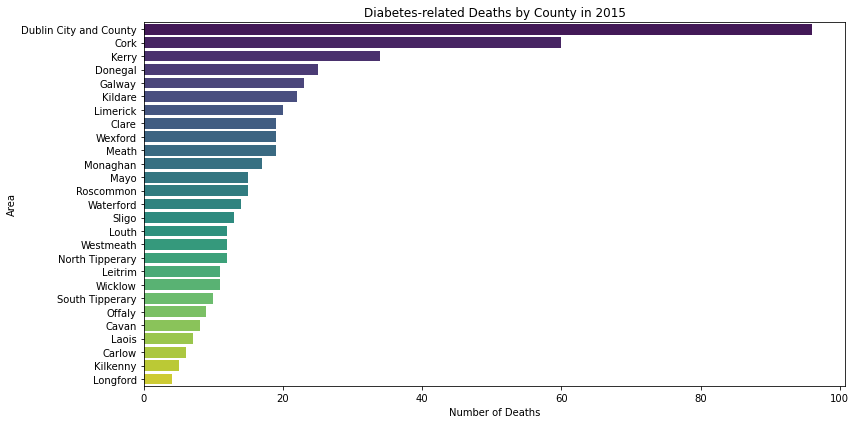

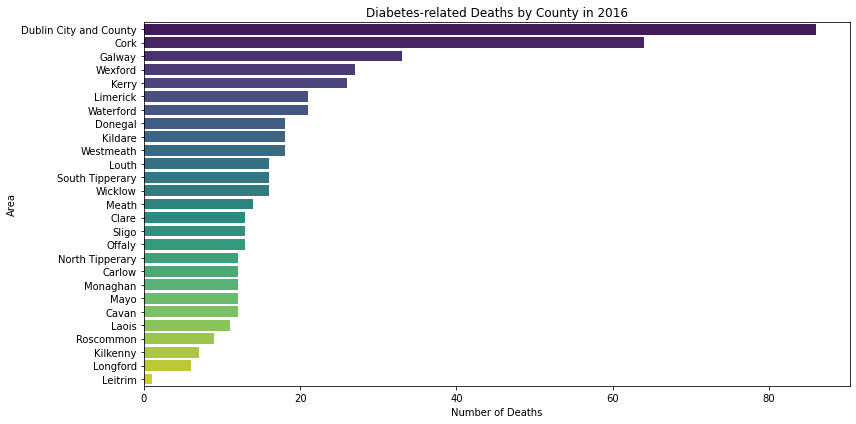

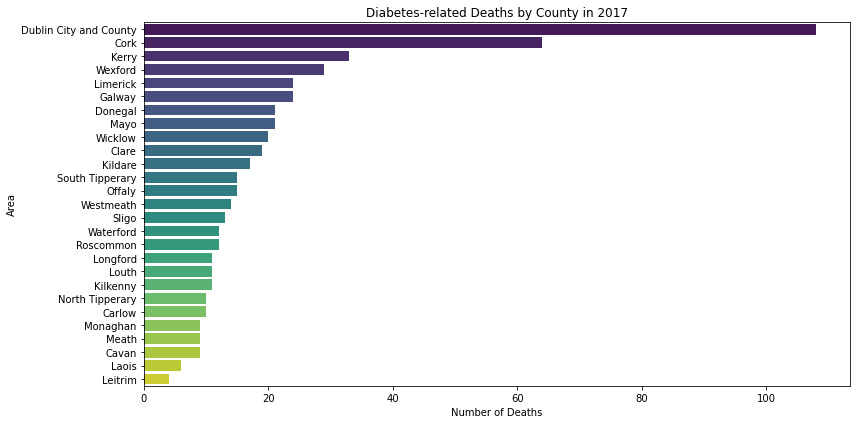

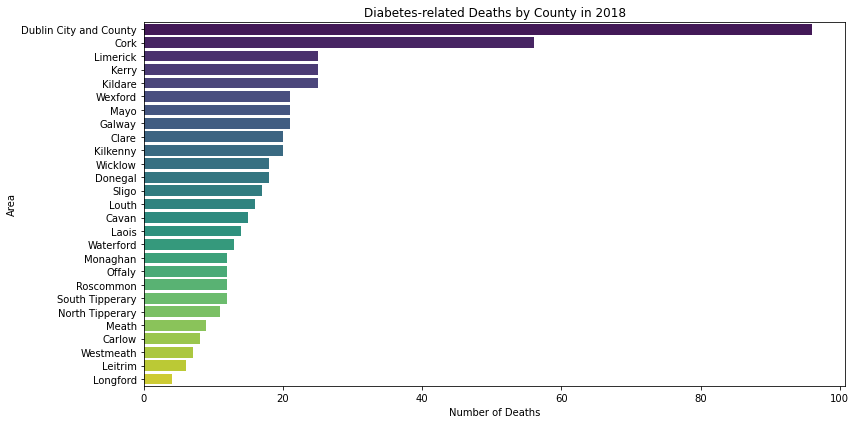

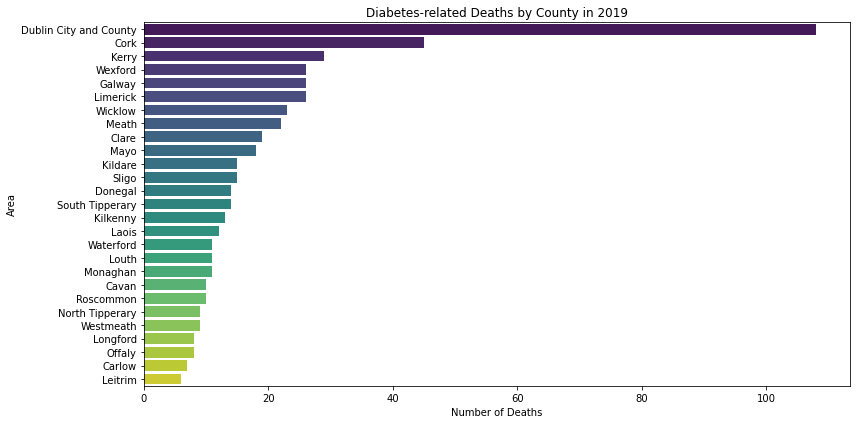

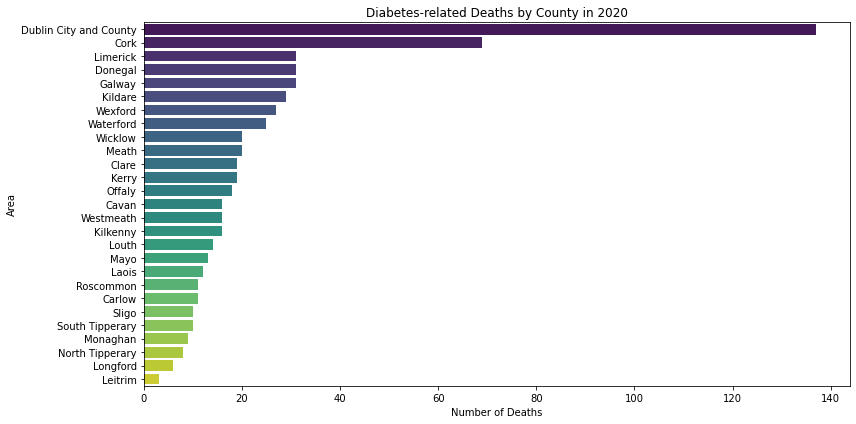

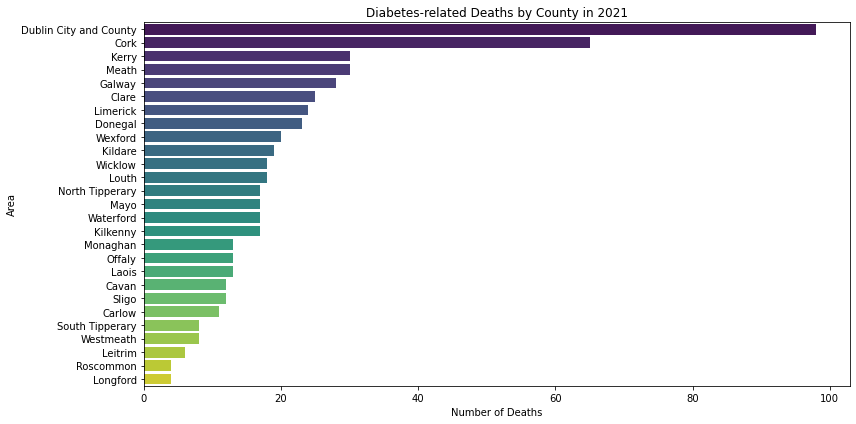

In [4]:
# Get the 5 most recent years in the data
recent_years = sorted(diabetes_filtered["Year"].unique())[-10:]

for year in recent_years:
    yearly_df = diabetes_filtered[diabetes_filtered["Year"] == year]
    regional_summary = yearly_df.groupby("Area")["VALUE"].sum().sort_values(ascending=False).reset_index()
    
    plt.figure(figsize=(12, 6))
    sns.barplot(data=regional_summary, x="VALUE", y="Area", palette="viridis")
    plt.title(f"Diabetes-related Deaths by County in {year}")
    plt.xlabel("Number of Deaths")
    plt.ylabel("Area")
    plt.tight_layout()
    plt.show()


## Diabetes death proportions county wise compared to other diseases

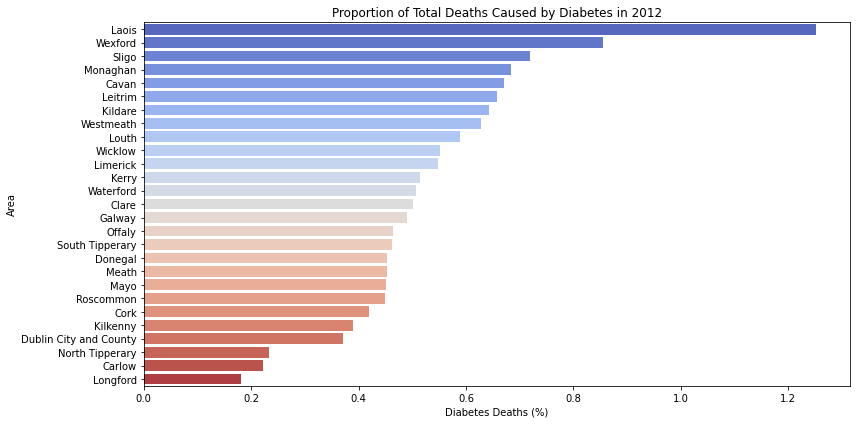

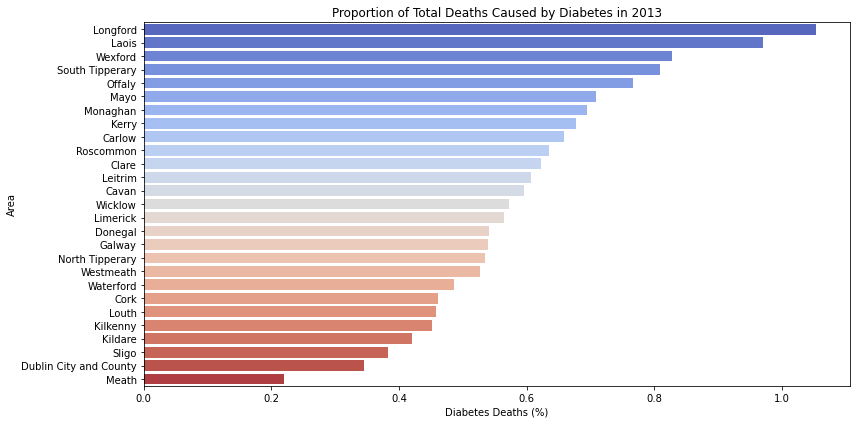

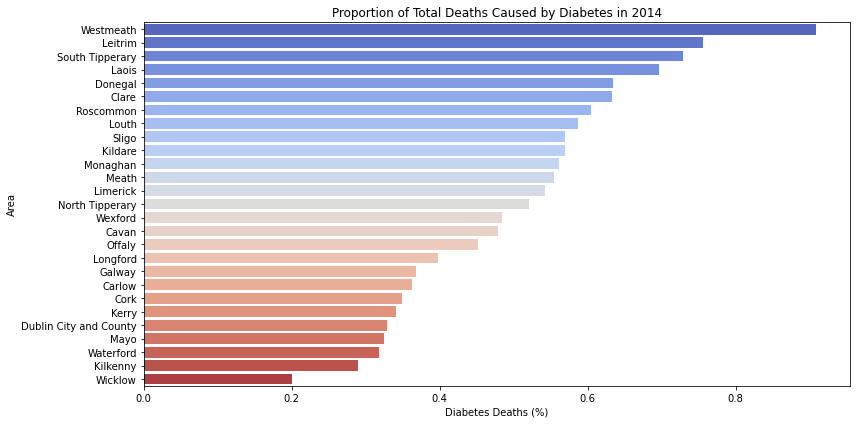

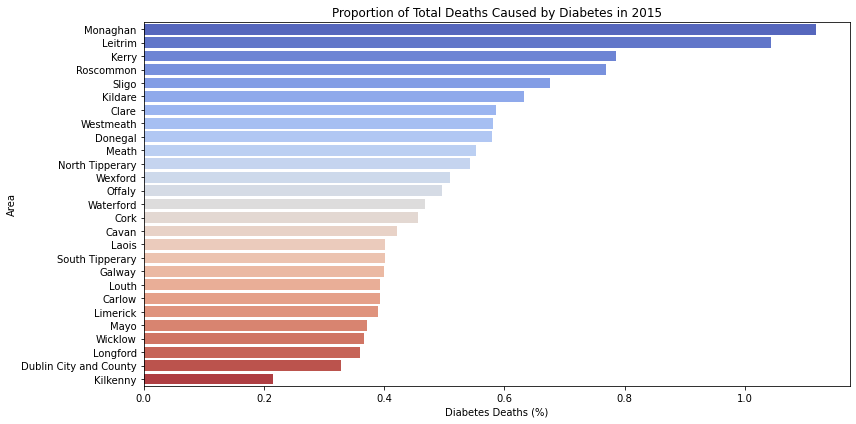

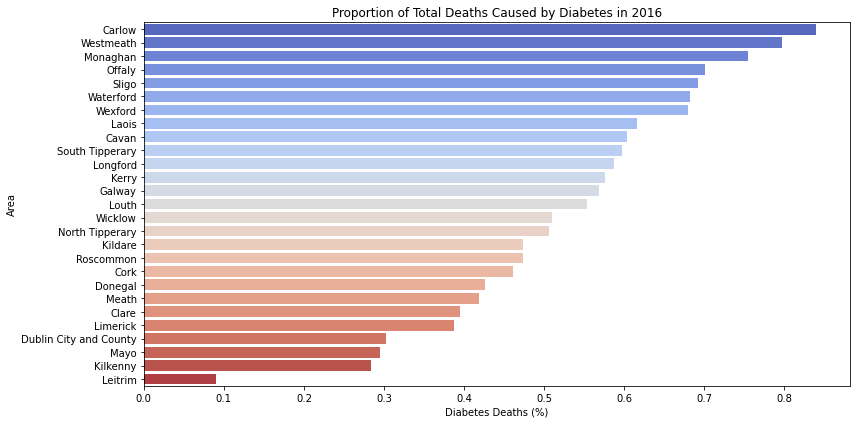

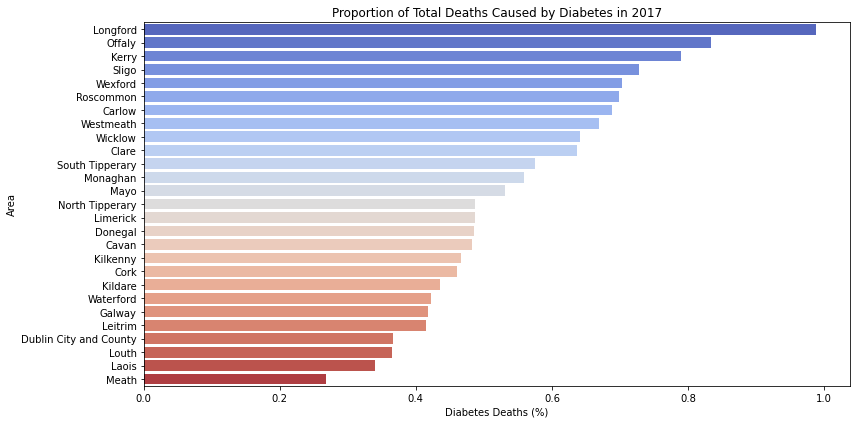

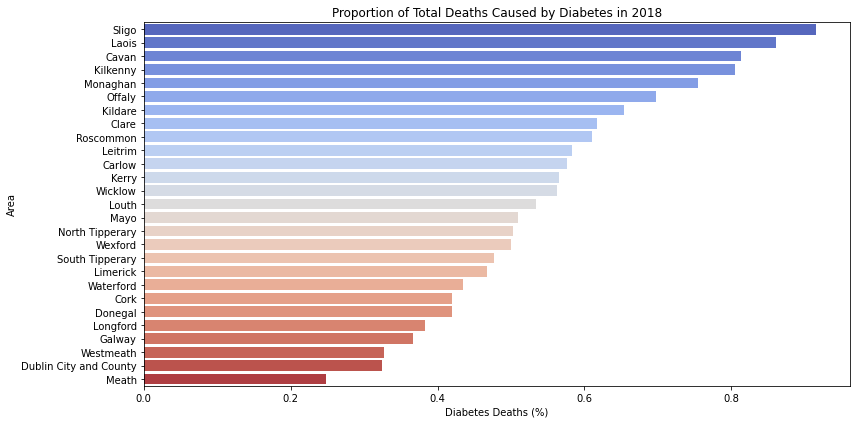

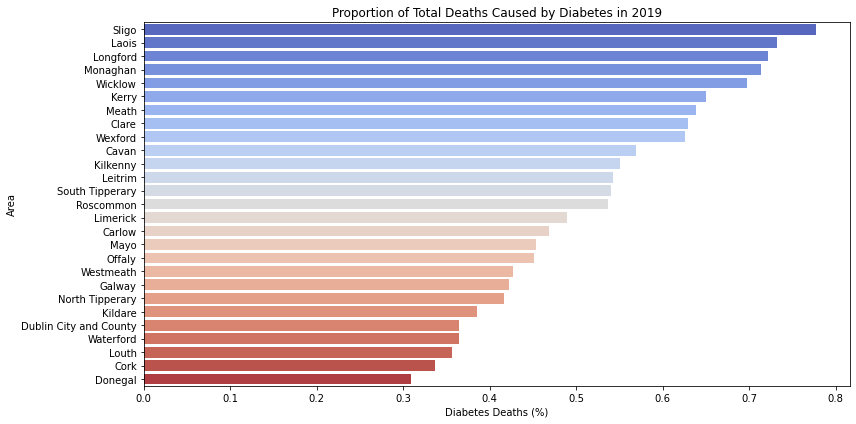

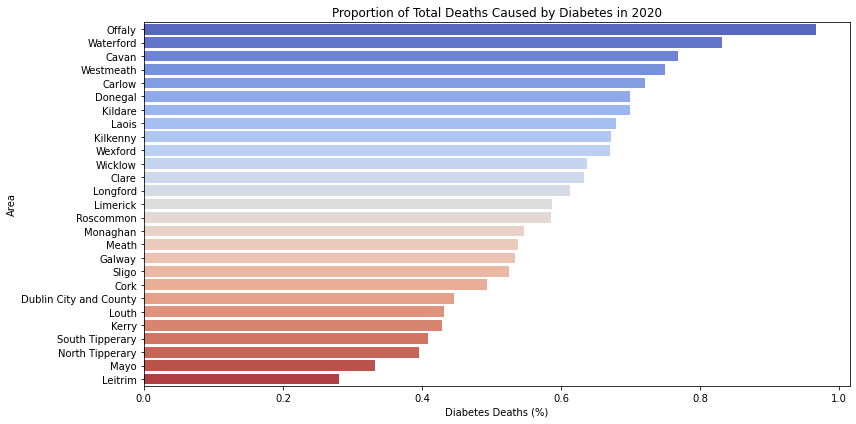

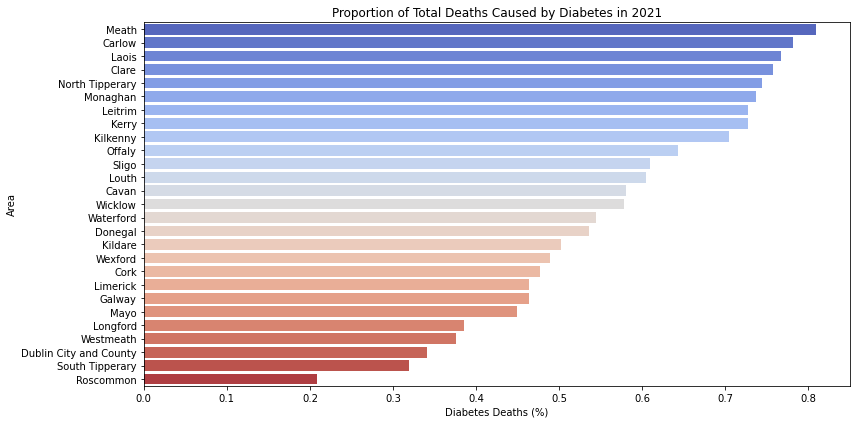

In [5]:
all_causes_df = df[
    (df["Statistic Label"] == "Deaths") &
    (df["Sex"] != "Both sexes") &
    (df["Area"] != "All counties and regions")
]

#diabetes_filtered = diabetes_df[
#    (diabetes_df["Sex"] != "Both sexes") &
#    (diabetes_df["Area"] != "All counties and regions")
#]

recent_years = sorted(diabetes_filtered["Year"].unique())[-10:]

for year in recent_years:
    # Total deaths (all causes)
    year_total = all_causes_df[all_causes_df["Year"] == year].groupby("Area")["VALUE"].sum().reset_index()
    
    # Diabetes deaths
    year_diabetes = diabetes_filtered[diabetes_filtered["Year"] == year].groupby("Area")["VALUE"].sum().reset_index()
    
    # Merge and compute percentage
    merged = pd.merge(year_diabetes, year_total, on="Area", suffixes=("_diabetes", "_total"))
    merged["% Diabetes Deaths"] = 100 * merged["VALUE_diabetes"] / merged["VALUE_total"]
    merged = merged.sort_values("% Diabetes Deaths", ascending=False)

    # Plot
    plt.figure(figsize=(12, 6))
    sns.barplot(data=merged, x="% Diabetes Deaths", y="Area", palette="coolwarm")
    plt.title(f"Proportion of Total Deaths Caused by Diabetes in {year}")
    plt.xlabel("Diabetes Deaths (%)")
    plt.ylabel("Area")
    plt.tight_layout()
    plt.show()

## Long-term Conditions

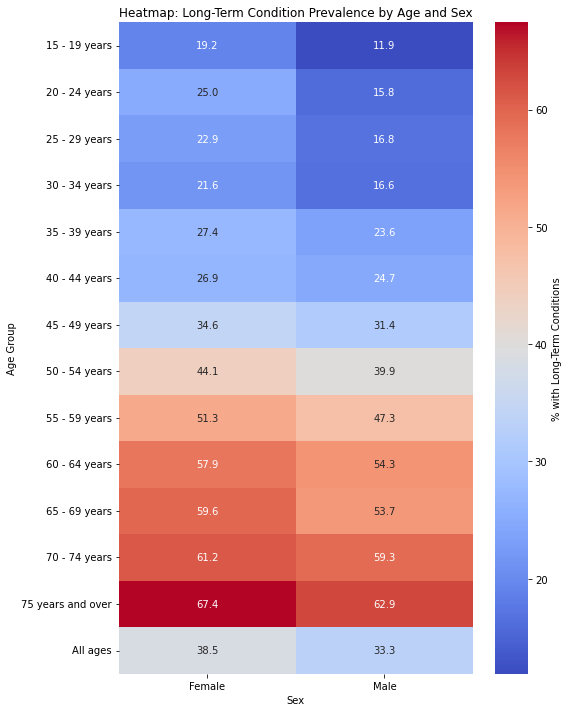

<Figure size 432x288 with 0 Axes>

In [6]:
df = pd.read_csv("Final\Long-term Conditions.csv")

# Filter to exclude 'Both sexes' for gender-specific analysis
sex_filtered = df[df["Sex"] != "Both sexes"]

agg_df = sex_filtered.groupby(["Age Group", "Sex"])["VALUE"].mean().reset_index()

# Pivot for heatmap
pivot_df = agg_df.pivot(index="Age Group", columns="Sex", values="VALUE").sort_index()

plt.figure(figsize=(8, 10))
sns.heatmap(
    pivot_df, annot=True, fmt=".1f", cmap="coolwarm", cbar_kws={'label': '% with Long-Term Conditions'}
)
plt.title("Heatmap: Long-Term Condition Prevalence by Age and Sex")
plt.xlabel("Sex")
plt.ylabel("Age Group")
plt.tight_layout()
plt.show()
plt.savefig("Chronic_conditions_heatmap.png")

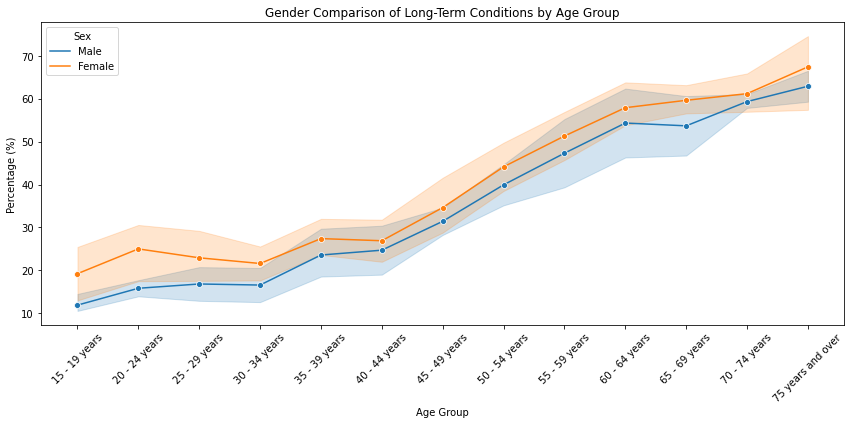

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv("Final\\Long-term Conditions.csv")

# Filter out 'Both sexes' and 'All Ages'
sex_filtered = df[(df["Sex"] != "Both sexes") & (df["Age Group"] != "All ages")]

# Plot the line chart
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=sex_filtered,
    x="Age Group", y="VALUE", hue="Sex", marker="o"
)
plt.title("Gender Comparison of Long-Term Conditions by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Percentage (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("Long_term_conditions.png")  # Save before showing
plt.show()


## Dataset preparations

## Interpolation From 2017 to 2021

In [4]:
import pandas as pd
import numpy as np
from scipy.interpolate import UnivariateSpline
df = pd.read_excel("Population.xlsx", sheet_name="Sheet1")
interp_years = [2017, 2018, 2019, 2020, 2021]
interpolated_data = []
# Perform interpolation for each (County, Sex) group
for (county, sex), group in df.groupby(["County", "Sex"]):
    group_sorted = group.sort_values("CensusYear")
    years = group_sorted["CensusYear"].values
    population = group_sorted["Population"].values
    # Fit spline and interpolate
    if len(years) >= 4:
        try:
            spline = UnivariateSpline(years, population, s=0)
            for year in interp_years:
                est_pop = spline(year)
                interpolated_data.append({
                    "County": county,
                    "Sex": sex,
                    "Year": year,
                    "Estimated_Population": round(float(est_pop))
                })
        except Exception as e:
            print(f"Interpolation failed for {county}, {sex}: {e}")
interpolated_df = pd.DataFrame(interpolated_data)
actual_2016 = df[df["CensusYear"] == 2016].copy()
actual_2016 = actual_2016.rename(columns={"CensusYear": "Year", "Population": "Estimated_Population"})
actual_2016 = actual_2016[["County", "Sex", "Year", "Estimated_Population"]]
actual_2022 = df[df["CensusYear"] == 2022].copy()
actual_2022 = actual_2022.rename(columns={"CensusYear": "Year", "Population": "Estimated_Population"})
actual_2022 = actual_2022[["County", "Sex", "Year", "Estimated_Population"]]
# Combine interpolated data and 2022
final_interp_df = pd.concat([interpolated_df, actual_2016, actual_2022], ignore_index=True).sort_values(by=["County", "Sex", "Year"])


In [5]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
# Load population data
df = pd.read_excel("Population.xlsx", sheet_name="Sheet1")
forecast_base_years = [1979, 1971, 1981, 1986, 1991, 1996, 2002, 2006, 2011, 2016, 2022]
forecast_years = [2023, 2024]
forecast_data = []
# Group by County and Sex
for (county, sex), group in df.groupby(["County", "Sex"]):
    group_filtered = group[group["CensusYear"].isin(forecast_base_years)].sort_values("CensusYear")
    years = group_filtered["CensusYear"].values
    population = group_filtered["Population"].values

    if len(years) >= 5:
        try:
            model = ARIMA(population, order=(1, 1, 0))
            model_fit = model.fit()
            forecast = model_fit.forecast(steps=len(forecast_years))

            for i, year in enumerate(forecast_years):
                forecast_data.append({
                    "County": county,
                    "Sex": sex,
                    "Year": year,
                    "Forecasted_Population": round(float(forecast[i]))
                })
        except Exception as e:
            print(f"Forecasting error for {county}, {sex}: {e}")

# Convert to DataFrame
forecast_df = pd.DataFrame(forecast_data)

In [6]:
final_interp_df[final_interp_df["County"] == "Clare"]

,County,Sex,Year,Estimated_Population
285,Clare,Female,2016,60032
20,Clare,Female,2017,60299
21,Clare,Female,2018,60715
22,Clare,Female,2019,61338
23,Clare,Female,2020,62224
24,Clare,Female,2021,63433
337,Clare,Female,2022,65021
284,Clare,Male,2016,58785
25,Clare,Male,2017,59025
26,Clare,Male,2018,59397


In [7]:
forecast_df[forecast_df["County"] == "Clare"]

,County,Sex,Year,Forecasted_Population
8,Clare,Female,2023,66055
9,Clare,Female,2024,66270
10,Clare,Male,2023,63684
11,Clare,Male,2024,63826


In [8]:
combined_df = pd.concat([
    interpolated_df,
    actual_2016,
    actual_2022,
    forecast_df.rename(columns={"Forecasted_Population": "Estimated_Population"})
], ignore_index=True).sort_values(by=["County", "Sex", "Year"])

In [9]:
combined_df = combined_df.reset_index(drop=True)

In [10]:
combined_df

,County,Sex,Year,Estimated_Population
0,Carlow,Female,2016,28467
1,Carlow,Female,2017,28724
2,Carlow,Female,2018,29029
3,Carlow,Female,2019,29403
4,Carlow,Female,2020,29867
...,...,...,...,...
463,Wicklow,Male,2020,73608
464,Wicklow,Male,2021,74954
465,Wicklow,Male,2022,76564
466,Wicklow,Male,2023,78871


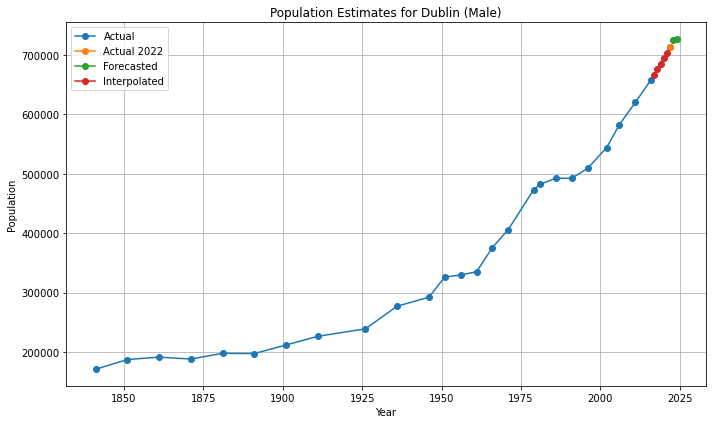

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

# Filter data for Dublin, Male
sample_actual = df[(df["County"] == "Dublin") & (df["Sex"] == "Male")].sort_values("CensusYear")
years_actual = sample_actual["CensusYear"].values
pop_actual = sample_actual["Population"].values

# Prepare visualization DataFrames
viz_actual = pd.DataFrame({
    "Year": years_actual,
    "Population": pop_actual,
    "Type": "Actual"
})

viz_interp = interpolated_df[(interpolated_df["County"] == "Dublin") & (interpolated_df["Sex"] == "Male")]
viz_forecast = forecast_df[(forecast_df["County"] == "Dublin") & (forecast_df["Sex"] == "Male")]
viz_2022 = actual_2022[(actual_2022["County"] == "Dublin") & (actual_2022["Sex"] == "Male")]

# Combine all
viz_all = pd.concat([
    viz_actual,
    viz_interp.rename(columns={"Estimated_Population": "Population"}).assign(Type="Interpolated"),
    viz_2022.rename(columns={"Estimated_Population": "Population"}).assign(Type="Actual 2022"),
    viz_forecast.rename(columns={"Forecasted_Population": "Population"}).assign(Type="Forecasted")
])

# Plot
plt.figure(figsize=(10, 6))
for label, grp in viz_all.groupby("Type"):
    plt.plot(grp["Year"], grp["Population"], marker='o', label=label)
plt.title("Population Estimates for Dublin (Male)")
plt.xlabel("Year")
plt.ylabel("Population")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


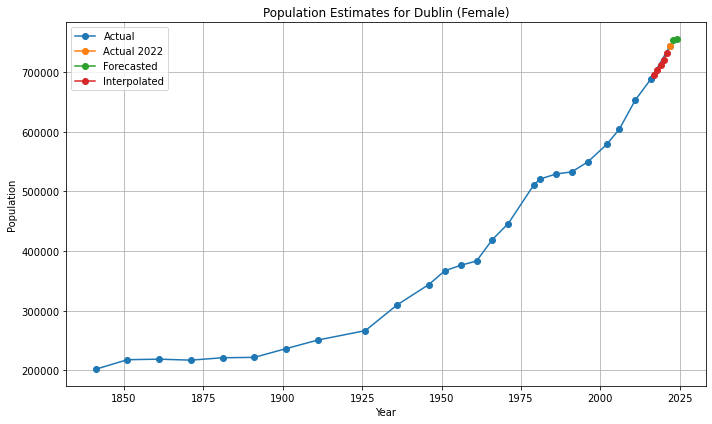

In [40]:
import matplotlib.pyplot as plt
import pandas as pd
# Filter data for Dublin, Female
sample_actual_f = df[(df["County"] == "Dublin") & (df["Sex"] == "Female")].sort_values("CensusYear")
years_actual_f = sample_actual_f["CensusYear"].values
pop_actual_f = sample_actual_f["Population"].values
# Prepare visualization DataFrames
viz_actual_f = pd.DataFrame({
    "Year": years_actual_f,
    "Population": pop_actual_f,
    "Type": "Actual"
})
viz_interp_f = interpolated_df[(interpolated_df["County"] == "Dublin") & (interpolated_df["Sex"] == "Female")]
viz_forecast_f = forecast_df[(forecast_df["County"] == "Dublin") & (forecast_df["Sex"] == "Female")]
viz_2022_f = actual_2022[(actual_2022["County"] == "Dublin") & (actual_2022["Sex"] == "Female")]

# Combine all
viz_all_f = pd.concat([
    viz_actual_f,
    viz_interp_f.rename(columns={"Estimated_Population": "Population"}).assign(Type="Interpolated"),
    viz_2022_f.rename(columns={"Estimated_Population": "Population"}).assign(Type="Actual 2022"),
    viz_forecast_f.rename(columns={"Forecasted_Population": "Population"}).assign(Type="Forecasted")
])
# Plot
plt.figure(figsize=(10, 6))
for label, grp in viz_all_f.groupby("Type"):
    plt.plot(grp["Year"], grp["Population"], marker='o', label=label)
plt.title("Population Estimates for Dublin (Female)")
plt.xlabel("Year")
plt.ylabel("Population")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


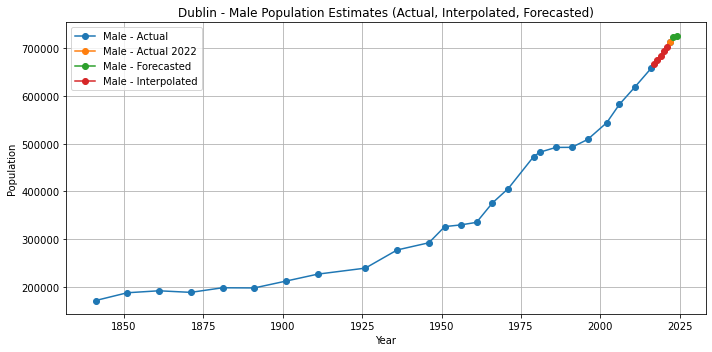

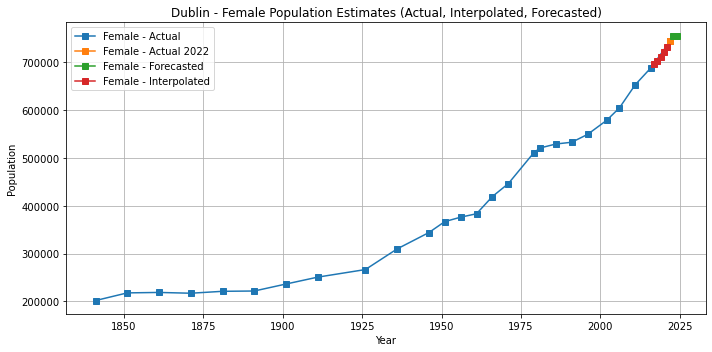

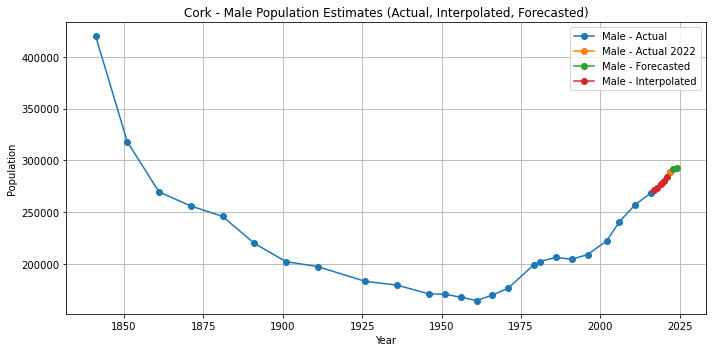

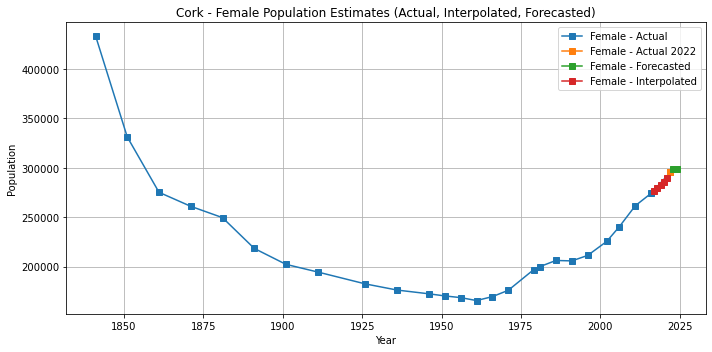

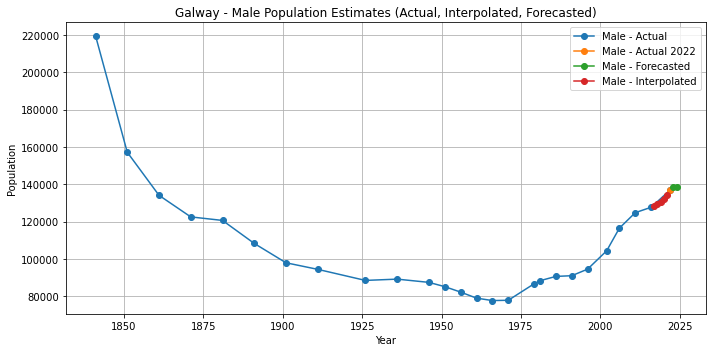

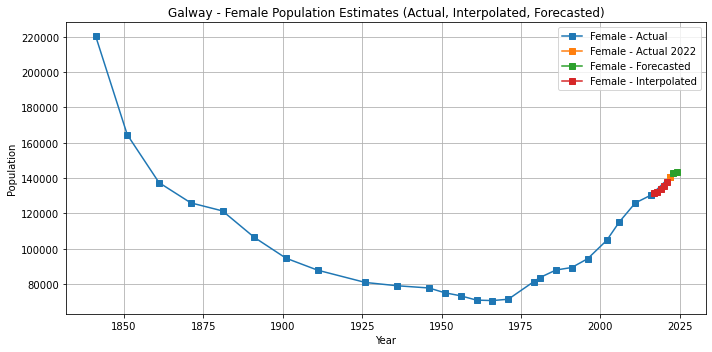

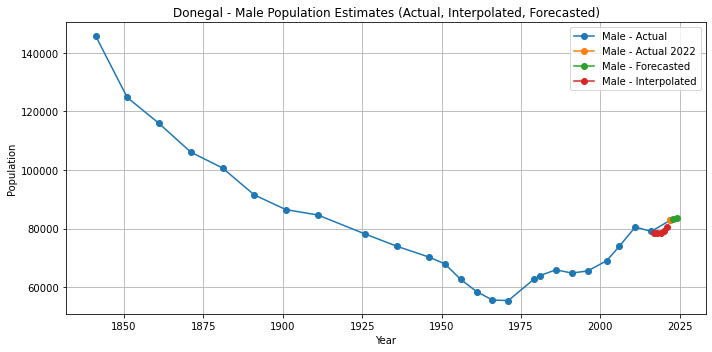

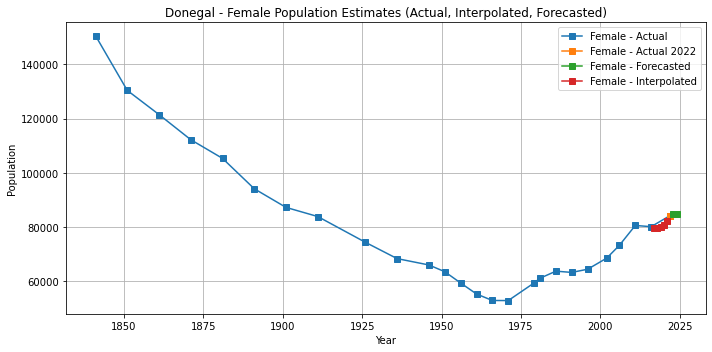

In [41]:
import matplotlib.pyplot as plt
import pandas as pd

# List of counties to plot individually
selected_counties = ["Dublin", "Cork", "Galway", "Donegal"]

# Helper function to prepare data by sex
def prepare_data(county, sex_label):
    actual = df[(df["County"] == county) & (df["Sex"] == sex_label)].sort_values("CensusYear")
    interp = interpolated_df[(interpolated_df["County"] == county) & (interpolated_df["Sex"] == sex_label)]
    forecast = forecast_df[(forecast_df["County"] == county) & (forecast_df["Sex"] == sex_label)]
    actual_2022_data = actual_2022[(actual_2022["County"] == county) & (actual_2022["Sex"] == sex_label)]

    return pd.concat([
        pd.DataFrame({
            "Year": actual["CensusYear"],
            "Population": actual["Population"],
            "Type": f"{sex_label} - Actual"
        }),
        interp.rename(columns={"Estimated_Population": "Population"}).assign(Type=f"{sex_label} - Interpolated")[["Year", "Population", "Type"]],
        forecast.rename(columns={"Forecasted_Population": "Population"}).assign(Type=f"{sex_label} - Forecasted")[["Year", "Population", "Type"]],
        actual_2022_data.rename(columns={"Estimated_Population": "Population"}).assign(Type=f"{sex_label} - Actual 2022")[["Year", "Population", "Type"]]
    ])

# Plotting one separate plot per county
for county in selected_counties:
    # Prepare male and female data
    male_data = prepare_data(county, "Male")
    female_data = prepare_data(county, "Female")

    # Plot male
    plt.figure(figsize=(10, 5))
    for label, grp in male_data.groupby("Type"):
        plt.plot(grp["Year"], grp["Population"], marker='o', label=label)
    plt.title(f"{county} - Male Population Estimates (Actual, Interpolated, Forecasted)")
    plt.xlabel("Year")
    plt.ylabel("Population")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{county.lower()}_male_population.png", dpi=300)
    plt.show()

    # Plot female
    plt.figure(figsize=(10, 5))
    for label, grp in female_data.groupby("Type"):
        plt.plot(grp["Year"], grp["Population"], marker='s', label=label)
    plt.title(f"{county} - Female Population Estimates (Actual, Interpolated, Forecasted)")
    plt.xlabel("Year")
    plt.ylabel("Population")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{county.lower()}_female_population.png", dpi=300)
    plt.show()


In [12]:
combined_df = combined_df[combined_df["Year"] != 2016]

In [13]:
combined_df

,County,Sex,Year,Estimated_Population
1,Carlow,Female,2017,28724
2,Carlow,Female,2018,29029
3,Carlow,Female,2019,29403
4,Carlow,Female,2020,29867
5,Carlow,Female,2021,30441
...,...,...,...,...
463,Wicklow,Male,2020,73608
464,Wicklow,Male,2021,74954
465,Wicklow,Male,2022,76564
466,Wicklow,Male,2023,78871


## Applying age proportions on esptimated population

In [14]:
age_group_proportions = {
    "0 - 14 years": 0.1878,
    "15 - 24 years": 0.1269,
    "25 - 34 years": 0.1374,
    "35 - 44 years": 0.1374,
    "45 - 54 years": 0.1279,
    "55 - 64 years": 0.1279,
    "65 - 74 years": 0.0774,
    "75 - 84 years": 0.0542,
    "85 years and over": 0.0232
}

age_prop_df = pd.DataFrame([
    {"Age Group": age, "Proportion": prop}
    for age, prop in age_group_proportions.items()
])


combined_df = combined_df.copy()
combined_df["key"] = 1

age_prop_df = age_prop_df.copy()
age_prop_df["key"] = 1

expanded_df = pd.merge(combined_df, age_prop_df, on="key").drop(columns="key")


expanded_df["Estimated_AgeGroup_Population"] = np.round(
    expanded_df["Estimated_Population"] * expanded_df["Proportion"]
).astype(int)

expanded_df = expanded_df[[
    "County", "Sex", "Year", "Age Group", "Estimated_AgeGroup_Population"
]]

diabetes_discharge = pd.read_excel("discharge_rate.xlsx", sheet_name = "Sheet1")

merged_df = pd.merge(expanded_df,diabetes_discharge,how="left",on=["Year", "Sex", "Age Group"])

merged_df["Estimated_Discharges"] = (
    merged_df["Estimated_AgeGroup_Population"] * merged_df["VALUE"]
) / 1000

merged_df["Estimated_Discharges"] = merged_df["Estimated_Discharges"].round().astype(int)


final_result = merged_df[[
    "County", "Year", "Sex", "Age Group",
    "Estimated_AgeGroup_Population", "Estimated_Discharges"
]]

final_result.rename(columns = {"Estimated_AgeGroup_Population" : "Estimated_Population"}, inplace = True)

C:\Users\DINESH\anaconda3\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [16]:
final_result

,County,Year,Sex,Age Group,Estimated_Population,Estimated_Discharges
0,Carlow,2017,Female,0 - 14 years,5394,3
1,Carlow,2017,Female,15 - 24 years,3645,3
2,Carlow,2017,Female,25 - 34 years,3947,3
3,Carlow,2017,Female,35 - 44 years,3947,3
4,Carlow,2017,Female,45 - 54 years,3674,4
...,...,...,...,...,...,...
3739,Wicklow,2024,Male,45 - 54 years,10194,30
3740,Wicklow,2024,Male,55 - 64 years,10194,66
3741,Wicklow,2024,Male,65 - 74 years,6169,61
3742,Wicklow,2024,Male,75 - 84 years,4320,42


In [17]:
final_result.to_excel("Final\estimated_discharges.xlsx", index=False)

In [18]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

# Load the diabetes ALOS dataset
diabetes_los_df = pd.read_excel("Diabetes LOS.xlsx")

# Filter to keep only ALOS entries
diabetes_alos = diabetes_los_df[
    diabetes_los_df["Statistic Label"] == "Average Length of Stay"
][["Year", "Age Group", "Sex", "VALUE"]].rename(columns={"VALUE": "Diabetes_ALOS"})

# Forecast settings
forecast_years = [2021, 2022, 2023, 2024]
forecast_rows = []

# Group by Age Group and Sex
for (age_group, sex), group in diabetes_alos.groupby(["Age Group", "Sex"]):
    group = group.dropna(subset=["Diabetes_ALOS"]).sort_values("Year")
    values = group["Diabetes_ALOS"].values

    # ARIMA needs at least 5 data points to work properly
    if len(values) >= 5:
        try:
            model = ARIMA(values, order=(1, 1, 0))  # You can tune (p,d,q) if needed
            model_fit = model.fit()
            forecast = model_fit.forecast(steps=len(forecast_years))
            for i, year in enumerate(forecast_years):
                forecast_rows.append({
                    "Year": year,
                    "Age Group": age_group,
                    "Sex": sex,
                    "Diabetes_ALOS": forecast[i],
                    "Source": "Forecast"
                })
        except Exception as e:
            print(f"ARIMA error for {age_group}, {sex}: {e}")

# Add source to actual data
diabetes_alos["Source"] = "Actual"

# Combine forecast and actual data
forecast_df = pd.DataFrame(forecast_rows)
combined_diabetes_alos = pd.concat([diabetes_alos, forecast_df], ignore_index=True)

# Optional: Save to Excel
combined_diabetes_alos.to_excel("Final\Diabetes_Alos.xlsx", index=False)

# Preview result
print(combined_diabetes_alos.tail(10))


     Year          Age Group     Sex  Diabetes_ALOS    Source
548  2023      75 - 84 years    Male      13.928817  Forecast
549  2024      75 - 84 years    Male      13.928937  Forecast
550  2021  85 years and over  Female      16.275886  Forecast
551  2022  85 years and over  Female      19.781094  Forecast
552  2023  85 years and over  Female      17.714094  Forecast
553  2024  85 years and over  Female      18.932991  Forecast
554  2021  85 years and over    Male      11.974252  Forecast
555  2022  85 years and over    Male      11.836968  Forecast
556  2023  85 years and over    Male      11.882464  Forecast
557  2024  85 years and over    Male      11.867387  Forecast


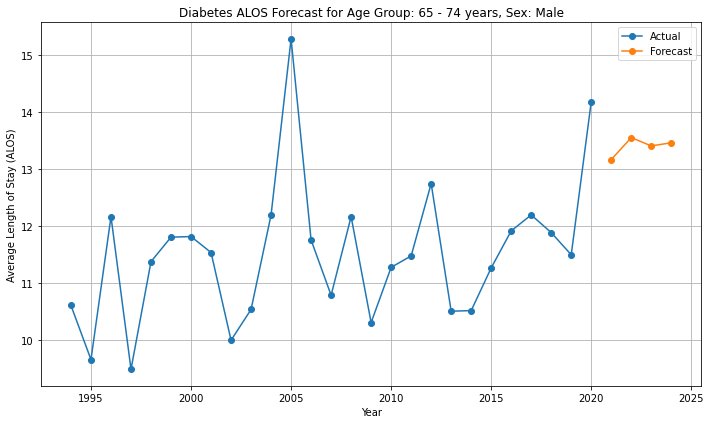

In [49]:
import matplotlib.pyplot as plt

# Filter data for one Age Group and Sex
selected_age_group = "65 - 74 years"
selected_sex = "Male"

plot_df = combined_diabetes_alos[
    (combined_diabetes_alos["Age Group"] == selected_age_group) &
    (combined_diabetes_alos["Sex"] == selected_sex)
].sort_values("Year")

# Plot
plt.figure(figsize=(10, 6))
for label, group in plot_df.groupby("Source"):
    plt.plot(group["Year"], group["Diabetes_ALOS"], marker='o', label=label)

plt.title(f"Diabetes ALOS Forecast for Age Group: {selected_age_group}, Sex: {selected_sex}")
plt.xlabel("Year")
plt.ylabel("Average Length of Stay (ALOS)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [15]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

# Load dataset
general_los_df = pd.read_excel("General LOS.xlsx")

# Filter to keep only Average Length of Stay entries
general_los_clean = general_los_df[
    general_los_df["Statistic Label"] == "Average Length of Stay"
][["Area", "Year", "Age Group", "Sex", "VALUE"]].rename(columns={
    "Area": "County",
    "VALUE": "General_ALOS"
})

# Forecast settings
forecast_years = [2022, 2023, 2024]
forecast_rows = []

# Group by County, Age Group, and Sex
grouped = general_los_clean.groupby(["County", "Age Group", "Sex"])

for (county, age_group, sex), group in grouped:
    group = group.dropna(subset=["General_ALOS"]).sort_values("Year")
    if len(group) >= 4:
        try:
            y = group["General_ALOS"].values
            model = ARIMA(y, order=(1, 1, 0))
            model_fit = model.fit()
            forecast = model_fit.forecast(steps=len(forecast_years))

            for i, year in enumerate(forecast_years):
                forecast_rows.append({
                    "County": county,
                    "Year": year,
                    "Age Group": age_group,
                    "Sex": sex,
                    "General_ALOS": float(forecast[i]),
                    "Source": "Forecast"
                })
        except Exception as e:
            print(f"Forecasting error for {county}, {age_group}, {sex}: {e}")

# Label actuals
general_los_clean["Source"] = "Actual"

# Combine with forecast
forecast_df = pd.DataFrame(forecast_rows)
combined_general_alos = pd.concat([general_los_clean, forecast_df], ignore_index=True)

# Optional: Save to Excel
combined_general_alos.to_excel("Final\General_Alos.xlsx", index=False)

# Preview
print(combined_general_alos.tail(10))


       County  Year          Age Group     Sex  General_ALOS    Source
9656  Wicklow  2024      75 - 84 years  Female     15.788697  Forecast
9657  Wicklow  2022      75 - 84 years    Male     15.090728  Forecast
9658  Wicklow  2023      75 - 84 years    Male     14.987958  Forecast
9659  Wicklow  2024      75 - 84 years    Male     15.023079  Forecast
9660  Wicklow  2022  85 years and over  Female     20.216003  Forecast
9661  Wicklow  2023  85 years and over  Female     20.215778  Forecast
9662  Wicklow  2024  85 years and over  Female     20.215786  Forecast
9663  Wicklow  2022  85 years and over    Male     18.999734  Forecast
9664  Wicklow  2023  85 years and over    Male     17.918416  Forecast
9665  Wicklow  2024  85 years and over    Male     18.494476  Forecast


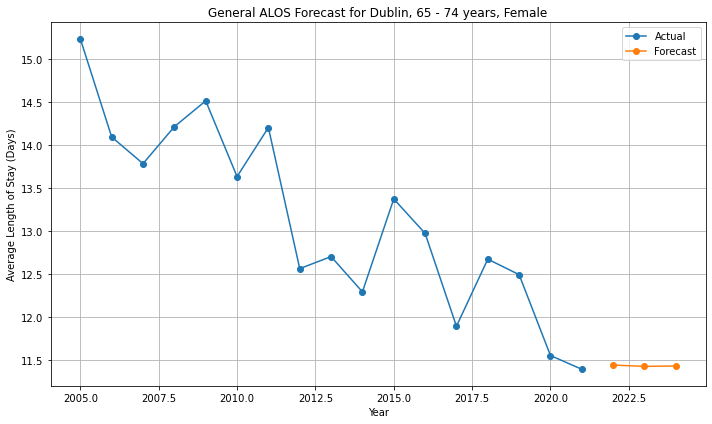

In [51]:
import matplotlib.pyplot as plt

# Choose a specific group to visualize
target_county = "Dublin"
target_age_group = "65 - 74 years"
target_sex = "Female"

# Filter the combined DataFrame
viz_df = combined_general_alos[
    (combined_general_alos["County"] == target_county) &
    (combined_general_alos["Age Group"] == target_age_group) &
    (combined_general_alos["Sex"] == target_sex)
].sort_values("Year")

# Plot
plt.figure(figsize=(10, 6))
for label, grp in viz_df.groupby("Source"):
    plt.plot(grp["Year"], grp["General_ALOS"], marker='o', label=label)

plt.title(f"General ALOS Forecast for {target_county}, {target_age_group}, {target_sex}")
plt.xlabel("Year")
plt.ylabel("Average Length of Stay (Days)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [19]:
discharges_df = pd.read_excel("Final\estimated_discharges.xlsx")
diabetes_los_df = pd.read_excel("Final\Diabetes_Alos.xlsx")
general_los_df = pd.read_excel("Final\General_Alos.xlsx")

In [20]:
discharges_df

,County,Year,Sex,Age Group,Estimated_Population,Estimated_Discharges
0,Carlow,2017,Female,0 - 14 years,5394,3
1,Carlow,2017,Female,15 - 24 years,3645,3
2,Carlow,2017,Female,25 - 34 years,3947,3
3,Carlow,2017,Female,35 - 44 years,3947,3
4,Carlow,2017,Female,45 - 54 years,3674,4
...,...,...,...,...,...,...
3739,Wicklow,2024,Male,45 - 54 years,10194,30
3740,Wicklow,2024,Male,55 - 64 years,10194,66
3741,Wicklow,2024,Male,65 - 74 years,6169,61
3742,Wicklow,2024,Male,75 - 84 years,4320,42


In [21]:
diabetes_los_df

,Year,Age Group,Sex,Diabetes_ALOS,Source
0,1994,0 - 14 years,Male,6.610000,Actual
1,1994,0 - 14 years,Female,6.290000,Actual
2,1994,15 - 24 years,Male,5.640000,Actual
3,1994,15 - 24 years,Female,6.070000,Actual
4,1994,25 - 34 years,Male,23.380000,Actual
...,...,...,...,...,...
553,2024,85 years and over,Female,18.932991,Forecast
554,2021,85 years and over,Male,11.974252,Forecast
555,2022,85 years and over,Male,11.836968,Forecast
556,2023,85 years and over,Male,11.882464,Forecast


In [22]:
general_los_df

,County,Year,Age Group,Sex,General_ALOS,Source
0,Dublin,2005,0 - 14 years,Male,5.110000,Actual
1,Dublin,2005,15 - 24 years,Male,5.220000,Actual
2,Dublin,2005,25 - 34 years,Male,6.230000,Actual
3,Dublin,2005,35 - 44 years,Male,7.500000,Actual
4,Dublin,2005,45 - 54 years,Male,9.440000,Actual
...,...,...,...,...,...,...
9661,Wicklow,2023,85 years and over,Female,20.215778,Forecast
9662,Wicklow,2024,85 years and over,Female,20.215786,Forecast
9663,Wicklow,2022,85 years and over,Male,18.999734,Forecast
9664,Wicklow,2023,85 years and over,Male,17.918416,Forecast


In [23]:
import pandas as pd


discharges_df = pd.read_excel("Final\estimated_discharges.xlsx")
diabetes_los_df = pd.read_excel("Final\Diabetes_Alos.xlsx")
general_los_df = pd.read_excel("Final\General_Alos.xlsx")


diabetes_los_clean = diabetes_los_df[["Year", "Age Group", "Sex", "Diabetes_ALOS"]]
general_los_clean = general_los_df[["County", "Year", "Age Group", "Sex", "General_ALOS"]]


alos_merged = pd.merge(
    general_los_clean, diabetes_los_clean,
    on=["Year", "Age Group", "Sex"], how="inner"
)
alos_merged["Scaling_Factor"] = alos_merged["Diabetes_ALOS"] / alos_merged["General_ALOS"]
alos_merged["Scaling_Factor"] = alos_merged["Scaling_Factor"] * 0.4


discharge_with_general = pd.merge(
    discharges_df, general_los_clean,
    on=["County", "Year", "Age Group", "Sex"], how="left"
)

final_df = pd.merge(
    discharge_with_general,
    alos_merged[["County", "Year", "Age Group", "Sex", "Scaling_Factor"]],
    on=["County", "Year", "Age Group", "Sex"], how="left"
)


final_df["Simulated_Diabetes_ALOS"] = final_df["General_ALOS"] * final_df["Scaling_Factor"]

columns_to_round = [
    "Diabetes_ALOS",
    "General_ALOS",
    "Simulated_Diabetes_ALOS",
    "Estimated_Discharges",
    "Estimated_Diabetes_Bed_Days"
]

for col in columns_to_round:
    if col in final_df.columns:
        final_df[col] = final_df[col].apply(lambda x: int(round(x)) if np.isfinite(x) else x)

final_df.to_excel("Final\simulated_los_data.xlsx", index=False)


In [24]:
final_df[(final_df["County"] == "Cork") & (final_df["Year"] == 2024)]

,County,Year,Sex,Age Group,Estimated_Population,Estimated_Discharges,General_ALOS,Scaling_Factor,Simulated_Diabetes_ALOS
495,Cork,2024,Female,0 - 14 years,56159,29,7.0,0.265103,2.0
496,Cork,2024,Female,15 - 24 years,37947,33,6.0,0.242054,1.0
497,Cork,2024,Female,25 - 34 years,41087,45,4.0,0.317843,1.0
498,Cork,2024,Female,35 - 44 years,41087,40,4.0,0.554590,2.0
499,Cork,2024,Female,45 - 54 years,38246,62,6.0,0.423008,3.0
500,Cork,2024,Female,55 - 64 years,38246,113,8.0,0.411664,3.0
501,Cork,2024,Female,65 - 74 years,23145,94,10.0,0.442410,5.0
502,Cork,2024,Female,75 - 84 years,16208,76,12.0,0.433750,5.0
503,Cork,2024,Female,85 years and over,6938,33,14.0,0.530178,8.0
567,Cork,2024,Male,0 - 14 years,54933,27,6.0,0.272031,2.0


In [25]:
import pandas as pd


df = pd.read_excel("Final\simulated_los_data.xlsx")

# Drop rows with any null
df_cleaned = df.dropna()

# Save the cleaned dataset to a new Excel file
df_cleaned.to_excel("Final\simulated_los_data_cleaned.xlsx", index=False)

# Display 
print("Cleaned dataset shape:", df_cleaned.shape)


Cleaned dataset shape: (3744, 9)


In [26]:
df_cleaned

,County,Year,Sex,Age Group,Estimated_Population,Estimated_Discharges,General_ALOS,Scaling_Factor,Simulated_Diabetes_ALOS
0,Carlow,2017,Female,0 - 14 years,5394,3,6.0,0.274165,2.0
1,Carlow,2017,Female,15 - 24 years,3645,3,3.0,0.341493,1.0
2,Carlow,2017,Female,25 - 34 years,3947,3,4.0,0.376536,1.0
3,Carlow,2017,Female,35 - 44 years,3947,3,4.0,0.485637,2.0
4,Carlow,2017,Female,45 - 54 years,3674,4,6.0,0.416482,3.0
...,...,...,...,...,...,...,...,...,...
4009,Wicklow,2024,Male,45 - 54 years,10194,30,8.0,0.316854,3.0
4010,Wicklow,2024,Male,55 - 64 years,10194,66,10.0,0.422771,4.0
4011,Wicklow,2024,Male,65 - 74 years,6169,61,11.0,0.484956,5.0
4012,Wicklow,2024,Male,75 - 84 years,4320,42,15.0,0.370868,6.0


In [ ]:
import pandas as pd

# Load the dataset
df = pd.read_excel("Final\simulated_los_data.xlsx")

# Drop rows with any null (NaN) values
df_cleaned = df.dropna()

# Optional: Save the cleaned dataset to a new Excel file
df_cleaned.to_excel("simulated_los_data_cleaned.xlsx", index=False)

# Display the shape of the cleaned dataset
print("Cleaned dataset shape:", df_cleaned.shape)


## Workforce

All visualizations saved to current directory.


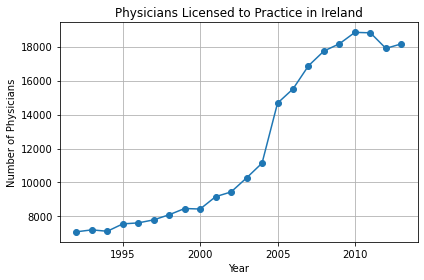

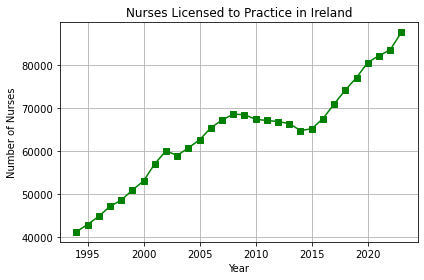

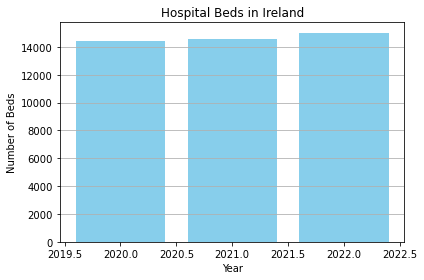

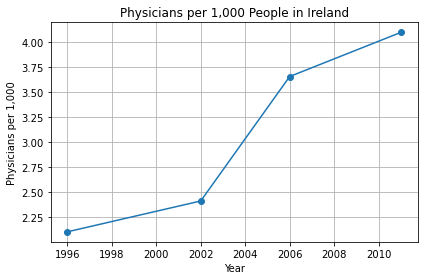

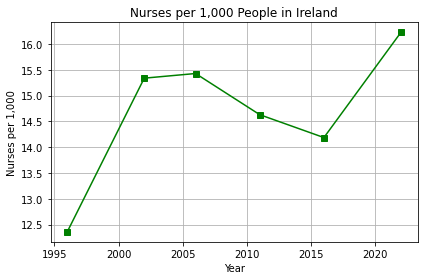

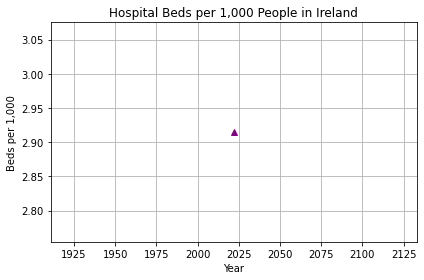

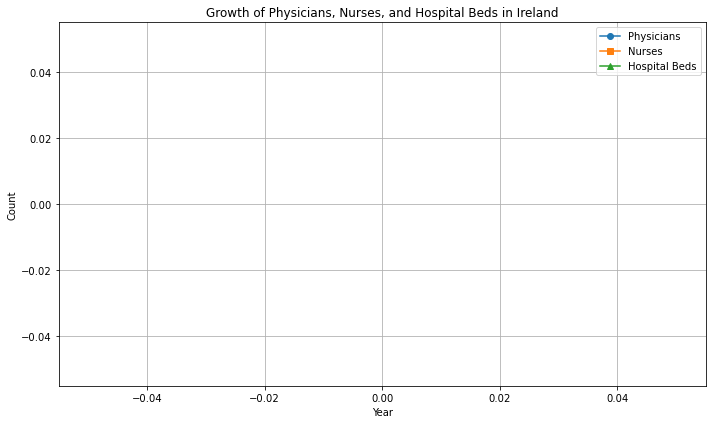

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load Excel file
file_path = "Final\Workforce.xlsx"
xls = pd.ExcelFile(file_path)

# Load sheets
nurses_df = xls.parse('Nurses')
physicians_df = xls.parse('Physicians')
population_df = xls.parse('Population')
beds_df = xls.parse('Hospital beds')

# Preprocess Population
population_by_year = (
    population_df.groupby("CensusYear")["Population"]
    .sum()
    .reset_index()
    .rename(columns={"CensusYear": "Year"})
)

# Merge for per-1,000 calculations
physicians_merged = pd.merge(physicians_df, population_by_year, on="Year", how="inner")
nurses_merged = pd.merge(nurses_df, population_by_year, on="Year", how="inner")
beds_merged = pd.merge(beds_df.rename(columns={"YEAR": "Year"}), population_by_year, on="Year", how="inner")

# Calculate per 1,000 population
physicians_merged["Physicians per 1,000"] = physicians_merged["VALUE"] / physicians_merged["Population"] * 1000
nurses_merged["Nurses per 1,000"] = nurses_merged["VALUE"] / nurses_merged["Population"] * 1000
beds_merged["Beds per 1,000"] = beds_merged["VALUE"] / beds_merged["Population"] * 1000

# ----------------------------
# Plot 1: Number of Physicians
plt.figure()
plt.plot(physicians_df["Year"], physicians_df["VALUE"], marker='o')
plt.title("Physicians Licensed to Practice in Ireland")
plt.xlabel("Year")
plt.ylabel("Number of Physicians")
plt.grid(True)
plt.tight_layout()
plt.savefig("physicians_count.png")

# ----------------------------
# Plot 2: Number of Nurses
plt.figure()
plt.plot(nurses_df["Year"], nurses_df["VALUE"], marker='s', color='green')
plt.title("Nurses Licensed to Practice in Ireland")
plt.xlabel("Year")
plt.ylabel("Number of Nurses")
plt.grid(True)
plt.tight_layout()
plt.savefig("nurses_count.png")

# ----------------------------
# Plot 3: Hospital Beds
plt.figure()
plt.bar(beds_df["YEAR"], beds_df["VALUE"], color='skyblue')
plt.title("Hospital Beds in Ireland")
plt.xlabel("Year")
plt.ylabel("Number of Beds")
plt.grid(axis='y')
plt.tight_layout()
plt.savefig("hospital_beds_count.png")

# ----------------------------
# Plot 4: Physicians per 1,000
plt.figure()
plt.plot(physicians_merged["Year"], physicians_merged["Physicians per 1,000"], marker='o')
plt.title("Physicians per 1,000 People in Ireland")
plt.xlabel("Year")
plt.ylabel("Physicians per 1,000")
plt.grid(True)
plt.tight_layout()
plt.savefig("physicians_ratio.png")

# ----------------------------
# Plot 5: Nurses per 1,000
plt.figure()
plt.plot(nurses_merged["Year"], nurses_merged["Nurses per 1,000"], marker='s', color='green')
plt.title("Nurses per 1,000 People in Ireland")
plt.xlabel("Year")
plt.ylabel("Nurses per 1,000")
plt.grid(True)
plt.tight_layout()
plt.savefig("nurses_ratio.png")

# ----------------------------
# Plot 6: Beds per 1,000
plt.figure()
plt.plot(beds_merged["Year"], beds_merged["Beds per 1,000"], marker='^', color='purple')
plt.title("Hospital Beds per 1,000 People in Ireland")
plt.xlabel("Year")
plt.ylabel("Beds per 1,000")
plt.grid(True)
plt.tight_layout()
plt.savefig("hospital_beds_ratio.png")

# ----------------------------
# Plot 7: Combined Plot (Doctors, Nurses, Beds)
common_years = set(physicians_merged["Year"]) & set(nurses_merged["Year"]) & set(beds_merged["Year"])
common_years = sorted(common_years)

physicians_common = physicians_merged[physicians_merged["Year"].isin(common_years)]
nurses_common = nurses_merged[nurses_merged["Year"].isin(common_years)]
beds_common = beds_merged[beds_merged["Year"].isin(common_years)]

plt.figure(figsize=(10, 6))
plt.plot(physicians_common["Year"], physicians_common["VALUE"], label="Physicians", marker='o')
plt.plot(nurses_common["Year"], nurses_common["VALUE"], label="Nurses", marker='s')
plt.plot(beds_common["Year"], beds_common["VALUE"], label="Hospital Beds", marker='^')
plt.title("Growth of Physicians, Nurses, and Hospital Beds in Ireland")
plt.xlabel("Year")
plt.ylabel("Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("combined_growth_plot.png")

print("All visualizations saved to current directory.")


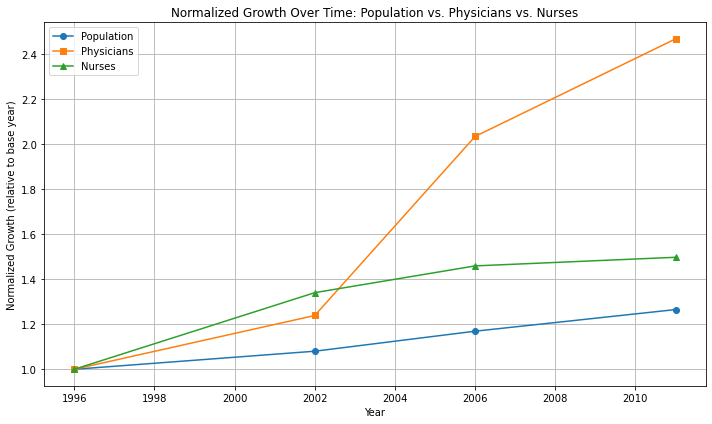

<Figure size 432x288 with 0 Axes>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt


xls = pd.ExcelFile("Final\Workforce.xlsx")

nurses_df = xls.parse("Nurses")
physicians_df = xls.parse("Physicians")
population_df = xls.parse("Population")


population_by_year = (
    population_df.groupby("CensusYear")["Population"]
    .sum()
    .reset_index()
    .rename(columns={"CensusYear": "Year"})
)


physicians_data = pd.merge(physicians_df[["Year", "VALUE"]].rename(columns={"VALUE": "Physicians"}), 
                           population_by_year, on="Year", how="inner")
nurses_data = pd.merge(nurses_df[["Year", "VALUE"]].rename(columns={"VALUE": "Nurses"}), 
                       population_by_year, on="Year", how="inner")


combined_df = pd.merge(physicians_data, nurses_data[["Year", "Nurses"]], on="Year", how="inner")

combined_df["Population (normalized)"] = combined_df["Population"] / combined_df["Population"].iloc[0]
combined_df["Physicians (normalized)"] = combined_df["Physicians"] / combined_df["Physicians"].iloc[0]
combined_df["Nurses (normalized)"] = combined_df["Nurses"] / combined_df["Nurses"].iloc[0]
plt.figure(figsize=(10, 6))
plt.plot(combined_df["Year"], combined_df["Population (normalized)"], label="Population", marker='o')
plt.plot(combined_df["Year"], combined_df["Physicians (normalized)"], label="Physicians", marker='s')
plt.plot(combined_df["Year"], combined_df["Nurses (normalized)"], label="Nurses", marker='^')

plt.title("Normalized Growth Over Time: Population vs. Physicians vs. Nurses")
plt.xlabel("Year")
plt.ylabel("Normalized Growth (relative to base year)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("normalized_growth_comparison.png")  # Save the figure
plt.show()
plt.savefig("normalized_growth_plot.png")


In [59]:
pip install pandas numpy matplotlib openpyxl xlsxwriter

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


DATA_PATH = r"C:\Users\DINESH\Downloads\Thesis\Final\simulated_los_data.xlsx"
OUTDIR = Path(r"C:\Users\DINESH\Downloads\Thesis\Final\preparam_outputs")
OUTDIR.mkdir(parents=True, exist_ok=True)

df = pd.read_excel(DATA_PATH)
df.columns = [c.strip() for c in df.columns]

# expected columns 
need = ["County","Year","Age Group","Sex",
        "Estimated_Discharges","General_ALOS","Scaling_Factor","Simulated_Diabetes_ALOS"]
missing = [c for c in need if c not in df.columns]
if missing:
    raise ValueError(f"Missing columns: {missing}")


if "Estimated_Diabetes_Bed_Days" not in df.columns:
    df["Estimated_Diabetes_Bed_Days"] = df["Estimated_Discharges"] * df["Simulated_Diabetes_ALOS"]


In [63]:
def bootstrap_ci_by_year(df, value_col, n_boot=1000, random_state=42):
    """Bootstrap across counties to get national-year CIs for a metric."""
    rng = np.random.default_rng(random_state)
    years = sorted(df["Year"].unique())
    counties = sorted(df["County"].unique())

    # pivot: rows counties, cols years -> sum over Age/Sex
    tmp = (df.groupby(["County","Year"], as_index=False)[value_col]
             .sum()
             .pivot(index="County", columns="Year", values=value_col)
             .reindex(index=counties, columns=years)
             .fillna(0.0)
          )

    means, lo, hi = [], [], []
    for y in years:
        col = tmp[y].values  # county totals for that year
        # bootstrap: sample counties with replacement, sum, repeat
        boot = []
        for _ in range(n_boot):
            sample = col[rng.integers(0, len(col), size=len(col))]
            boot.append(sample.sum())
        boot = np.array(boot)
        means.append(col.sum())             # actual national total (sum of counties)
        lo.append(np.percentile(boot, 2.5)) # 95% CI
        hi.append(np.percentile(boot, 97.5))
    out = pd.DataFrame({"Year": years, "Mean": means, "CI_low": lo, "CI_high": hi})
    return out

# A) national discharges
nat_dis = bootstrap_ci_by_year(df, "Estimated_Discharges", n_boot=1500)

# B) national diabetes bed-days
nat_bed = bootstrap_ci_by_year(df, "Estimated_Diabetes_Bed_Days", n_boot=1500)

# C) national ALOS (general vs simulated diabetes), averaged over age/sex weighted by discharges
def nat_alos_weighted(df, alos_col):
    g = (df.groupby(["Year","County"], as_index=False)
           .apply(lambda g: pd.Series({
               "wALOS": np.average(g[alos_col], weights=g["Estimated_Discharges"])
           }))
         )  # county-level weighted ALOS each year
    nat = g.groupby("Year", as_index=False)["wALOS"].mean()  # mean across counties
    nat = nat.rename(columns={"wALOS":"Mean"})
    return nat

nat_g_alos = nat_alos_weighted(df, "General_ALOS")
nat_d_alos = nat_alos_weighted(df, "Simulated_Diabetes_ALOS")


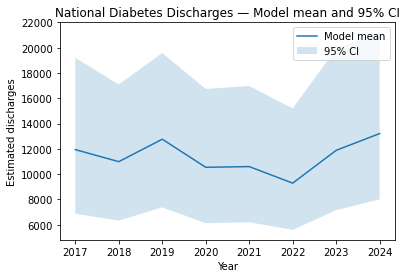

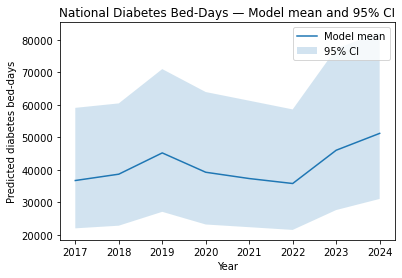

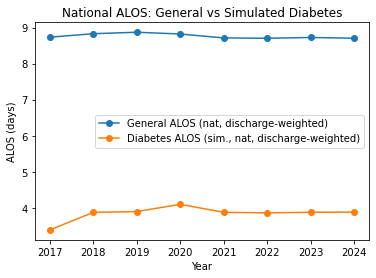

In [67]:
# A) Discharges per year with 95% CI
plt.figure()
plt.plot(nat_dis["Year"], nat_dis["Mean"], label="Model mean")
plt.fill_between(nat_dis["Year"], nat_dis["CI_low"], nat_dis["CI_high"], alpha=0.2, label="95% CI")
plt.xlabel("Year"); plt.ylabel("Estimated discharges")
plt.title("National Diabetes Discharges — Model mean and 95% CI")
plt.legend()
plt.show()
p1 = OUTDIR / "plot_national_discharges_ci.png"
plt.tight_layout(); plt.savefig(p1, dpi=180); plt.close()

# B) Bed-days per year with 95% CI
plt.figure()
plt.plot(nat_bed["Year"], nat_bed["Mean"], label="Model mean")
plt.fill_between(nat_bed["Year"], nat_bed["CI_low"], nat_bed["CI_high"], alpha=0.2, label="95% CI")
plt.xlabel("Year"); plt.ylabel("Predicted diabetes bed-days")
plt.title("National Diabetes Bed-Days — Model mean and 95% CI")
plt.legend()
plt.show()
p2 = OUTDIR / "plot_national_beddays_ci.png"
plt.tight_layout(); plt.savefig(p2, dpi=180); plt.close()

# C) ALOS comparison (general vs simulated diabetes)
plt.figure()
plt.plot(nat_g_alos["Year"], nat_g_alos["Mean"], marker="o", label="General ALOS (nat, discharge-weighted)")
plt.plot(nat_d_alos["Year"], nat_d_alos["Mean"], marker="o", label="Diabetes ALOS (sim., nat, discharge-weighted)")
plt.xlabel("Year"); plt.ylabel("ALOS (days)")
plt.title("National ALOS: General vs Simulated Diabetes")
plt.legend()
plt.show()
p3 = OUTDIR / "plot_national_alos_comparison.png"
plt.tight_layout(); plt.savefig(p3, dpi=180); plt.close()


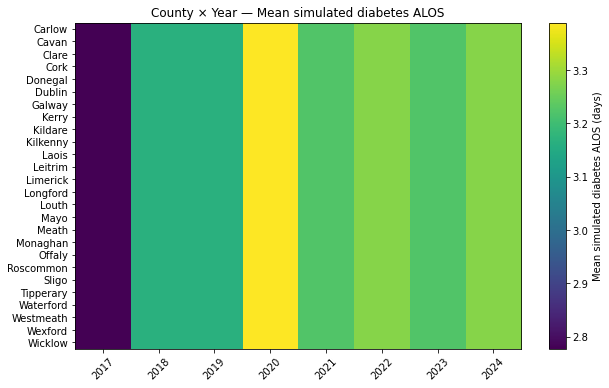

In [68]:
county_dhat = (df.groupby(["County","Year"], as_index=False)["Simulated_Diabetes_ALOS"]
                 .mean()
                 .pivot(index="County", columns="Year", values="Simulated_Diabetes_ALOS")
                 .sort_index()
              )
plt.figure(figsize=(10,6))
im = plt.imshow(county_dhat.values, aspect="auto")
plt.colorbar(im, label="Mean simulated diabetes ALOS (days)")
plt.yticks(ticks=np.arange(len(county_dhat.index)), labels=county_dhat.index)
plt.xticks(ticks=np.arange(len(county_dhat.columns)), labels=county_dhat.columns, rotation=45)
plt.title("County × Year — Mean simulated diabetes ALOS")
plt.show()
p4 = OUTDIR / "heatmap_county_year_dhat.png"
plt.tight_layout(); plt.savefig(p4, dpi=180); plt.close()


In [66]:
# merge national tables into one
tab_nat = (nat_dis.rename(columns={"Mean":"Discharges_mean","CI_low":"Discharges_CI_low","CI_high":"Discharges_CI_high"})
           .merge(nat_bed.rename(columns={"Mean":"BedDays_mean","CI_low":"BedDays_CI_low","CI_high":"BedDays_CI_high"}),
                  on="Year", how="outer")
          ).sort_values("Year")

# county-year stats for ALOS_sim
county_stats = (df.groupby(["County","Year"], as_index=False)
                  .agg(Dhat_mean=("Simulated_Diabetes_ALOS","mean"),
                       Dhat_min=("Simulated_Diabetes_ALOS","min"),
                       Dhat_max=("Simulated_Diabetes_ALOS","max"))
               )

# save tables to Excel
xlsx = OUTDIR / "preparam_summary_tables.xlsx"
with pd.ExcelWriter(xlsx, engine="xlsxwriter") as w:
    df.to_excel(w, index=False, sheet_name="input_simulated_los")
    tab_nat.to_excel(w, index=False, sheet_name="national_yearly")
    county_stats.to_excel(w, index=False, sheet_name="county_year_dhat")

tab_nat.head(), county_stats.head(), [str(x) for x in [p1,p2,p3,p4,xlsx]]


(   Year  Discharges_mean  Discharges_CI_low  Discharges_CI_high  BedDays_mean  \
 0  2017            11942           6869.225           19201.925       36750.0   
 1  2018            10988           6316.900           17099.975       38696.0   
 2  2019            12764           7370.700           19583.875       45234.0   
 3  2020            10542           6116.600           16745.575       39290.0   
 4  2021            10597           6194.325           16976.350       37355.0   
 
    BedDays_CI_low  BedDays_CI_high  
 0       22049.425        59078.650  
 1       22864.825        60447.350  
 2       27126.700        70994.625  
 3       23232.350        63941.450  
 4       22405.900        61281.075  ,
    County  Year  Dhat_mean  Dhat_min  Dhat_max
 0  Carlow  2017   2.777778       1.0       5.0
 1  Carlow  2018   3.166667       1.0       6.0
 2  Carlow  2019   3.166667       1.0       6.0
 3  Carlow  2020   3.388889       1.0       9.0
 4  Carlow  2021   3.222222       1.0

In [72]:
from IPython.display import display  

# Save .tex for thesis
with open(OUTDIR / "Table_ScalingFactor.tex", "w", encoding="utf-8") as f:
    f.write(sf_table_tex.to_latex(index=False, float_format="%.3f", escape=False))

# Display in local environment
print("\n=== National Scaling Factor Table ===")
display(sf_table_tex) 



=== National Scaling Factor Table ===


,Year,Age group,Sex,National General ALOS,National Diabetes ALOS,Scaling Factor
0,2005,0 - 14 years,Female,5.533333,4.310000,0.311566
1,2005,0 - 14 years,Male,4.770000,4.290000,0.359748
2,2005,15 - 24 years,Female,4.186667,3.630000,0.346815
3,2005,15 - 24 years,Male,4.756667,3.650000,0.306938
4,2005,25 - 34 years,Female,4.023333,6.720000,0.668103
...,...,...,...,...,...,...
355,2024,65 - 74 years,Male,11.759217,13.466784,0.458084
356,2024,75 - 84 years,Female,13.994349,13.343486,0.381396
357,2024,75 - 84 years,Male,14.096083,13.928937,0.395257
358,2024,85 years and over,Female,16.710531,18.932991,0.453199


In [73]:
with open(OUTDIR / "Table_General_vs_Simulated_ALOS.tex", "w", encoding="utf-8") as f:
    f.write(tab_tex.to_latex(index=False, float_format="%.2f", escape=False))

print("\n=== General vs Simulated Diabetes ALOS Table (Sample Counties) ===")
display(tab_tex)  



=== General vs Simulated Diabetes ALOS Table (Sample Counties) ===


,Year,County,Age group,Sex,General ALOS,Simulated Diabetes ALOS
9,2005,Cork,0 - 14 years,Male,4.490000,1.615270
10,2005,Cork,15 - 24 years,Male,4.060000,1.246167
11,2005,Cork,25 - 34 years,Male,4.510000,1.440945
12,2005,Cork,35 - 44 years,Male,5.640000,2.533196
13,2005,Cork,45 - 54 years,Male,6.880000,3.715713
...,...,...,...,...,...,...
1067,2024,Galway,65 - 74 years,Male,11.434608,5.238015
1070,2024,Galway,75 - 84 years,Female,12.440987,4.744948
1073,2024,Galway,75 - 84 years,Male,12.430485,4.913235
1076,2024,Galway,85 years and over,Female,14.559583,6.598389


In [77]:
tab_tex[(tab_tex["County"] == "Cork") & (tab_tex["Year"] == 2024)]

,Year,County,Age group,Sex,General ALOS,Simulated Diabetes ALOS
920,2024,Cork,0 - 14 years,Female,6.555717,1.754939
923,2024,Cork,0 - 14 years,Male,6.056695,1.706852
926,2024,Cork,15 - 24 years,Female,5.519420,1.672218
929,2024,Cork,15 - 24 years,Male,4.275931,1.082135
932,2024,Cork,25 - 34 years,Female,3.712370,1.233243
935,2024,Cork,25 - 34 years,Male,4.608900,0.866120
938,2024,Cork,35 - 44 years,Female,4.027697,2.232773
941,2024,Cork,35 - 44 years,Male,6.107452,1.754332
944,2024,Cork,45 - 54 years,Female,6.277766,2.402972
947,2024,Cork,45 - 54 years,Male,7.845900,2.486471


In [75]:
final_df[(final_df["County"] == "Cork") & (final_df["Year"] == 2024)]

,County,Year,Sex,Age Group,Estimated_Population,Estimated_Discharges,General_ALOS,Scaling_Factor,Simulated_Diabetes_ALOS
495,Cork,2024,Female,0 - 14 years,56159,29,7.0,0.265103,2.0
496,Cork,2024,Female,15 - 24 years,37947,33,6.0,0.242054,1.0
497,Cork,2024,Female,25 - 34 years,41087,45,4.0,0.317843,1.0
498,Cork,2024,Female,35 - 44 years,41087,40,4.0,0.554590,2.0
499,Cork,2024,Female,45 - 54 years,38246,62,6.0,0.423008,3.0
500,Cork,2024,Female,55 - 64 years,38246,113,8.0,0.411664,3.0
501,Cork,2024,Female,65 - 74 years,23145,94,10.0,0.442410,5.0
502,Cork,2024,Female,75 - 84 years,16208,76,12.0,0.433750,5.0
503,Cork,2024,Female,85 years and over,6938,33,14.0,0.530178,8.0
567,Cork,2024,Male,0 - 14 years,54933,27,6.0,0.272031,2.0


In [4]:

import numpy as np
from pathlib import Path

OUTDIR = Path("Final")
OUTDIR.mkdir(exist_ok=True, parents=True)

# pick ONE county (change as needed)
COUNTY = "Dublin"

# keep latest year only (comment this out if you want all years)
one_cnt = final_df[final_df["County"] == COUNTY].copy()
latest_year = one_cnt["Year"].max()
one_cnt = one_cnt[one_cnt["Year"] == latest_year].copy()

# columns for the table
cols = ["Year", "County", "Age Group", "Sex", "General_ALOS", "Simulated_Diabetes_ALOS"]
one_cnt = one_cnt[cols].sort_values(["Year","County","Age Group","Sex"])

# helper: write row-only LaTeX (no tabular env)
def df_to_tex_rows(df, float_fmt="%.2f"):
    rows = []
    for _, r in df.iterrows():
        vals = []
        for v in r:
            if isinstance(v, (float, np.floating)):
                vals.append(float_fmt % v)
            else:
                vals.append(str(v))
        rows.append(" & ".join(vals) + r" \\")
    return "\n".join(rows)


tex_path = OUTDIR / f"Table_Baseline_ALOS_{COUNTY}_rows.tex"
with open(tex_path, "w", encoding="utf-8") as f:
    f.write(df_to_tex_rows(one_cnt, float_fmt="%.2f"))

print(f"Saved LaTeX rows to: {tex_path.resolve()}")
print(one_cnt.head(10).to_string(index=False))  # quick preview in console


Saved LaTeX rows to: C:\Users\DINESH\Downloads\Thesis\Final\Table_Baseline_ALOS_Dublin_rows.tex
 Year County     Age Group    Sex  General_ALOS  Simulated_Diabetes_ALOS
 2024 Dublin  0 - 14 years Female           7.0                      2.0
 2024 Dublin  0 - 14 years   Male           6.0                      2.0
 2024 Dublin 15 - 24 years Female           4.0                      1.0
 2024 Dublin 15 - 24 years   Male           5.0                      1.0
 2024 Dublin 25 - 34 years Female           3.0                      1.0
 2024 Dublin 25 - 34 years   Male           6.0                      1.0
 2024 Dublin 35 - 44 years Female           4.0                      2.0
 2024 Dublin 35 - 44 years   Male           7.0                      2.0
 2024 Dublin 45 - 54 years Female           7.0                      3.0
 2024 Dublin 45 - 54 years   Male           9.0                      3.0


## Scaling factor alpha = 0.2

In [22]:
import pandas as pd


discharges_df = pd.read_excel("Final\estimated_discharges.xlsx")
diabetes_los_df = pd.read_excel("Final\Diabetes_Alos.xlsx")
general_los_df = pd.read_excel("Final\General_Alos.xlsx")


diabetes_los_clean = diabetes_los_df[["Year", "Age Group", "Sex", "Diabetes_ALOS"]]
general_los_clean = general_los_df[["County", "Year", "Age Group", "Sex", "General_ALOS"]]


alos_merged = pd.merge(
    general_los_clean, diabetes_los_clean,
    on=["Year", "Age Group", "Sex"], how="inner"
)
alos_merged["Scaling_Factor"] = alos_merged["Diabetes_ALOS"] / alos_merged["General_ALOS"]
alos_merged["Scaling_Factor"] = alos_merged["Scaling_Factor"] * 0.2


discharge_with_general = pd.merge(
    discharges_df, general_los_clean,
    on=["County", "Year", "Age Group", "Sex"], how="left"
)


final_df = pd.merge(
    discharge_with_general,
    alos_merged[["County", "Year", "Age Group", "Sex", "Scaling_Factor"]],
    on=["County", "Year", "Age Group", "Sex"], how="left"
)


final_df["Simulated_Diabetes_ALOS"] = final_df["General_ALOS"] * final_df["Scaling_Factor"]

columns_to_round = [
    "Diabetes_ALOS",
    "General_ALOS",
    "Simulated_Diabetes_ALOS",
    "Estimated_Discharges",
    "Estimated_Diabetes_Bed_Days"
]

for col in columns_to_round:
    if col in final_df.columns:
        final_df[col] = final_df[col].apply(lambda x: int(round(x)) if np.isfinite(x) else x)

final_df = final_df = final_df.dropna(subset=["Simulated_Diabetes_ALOS"])

final_df.to_excel("Final\simulated_los_data.xlsx", index=False)


In [6]:
# --- add near top ---
import numpy as np
from pathlib import Path

OUTDIR = Path("Final")
OUTDIR.mkdir(exist_ok=True, parents=True)

# pick ONE county (change as needed)
COUNTY = "Dublin"

# keep latest year only (comment this out if you want all years)
one_cnt = final_df[final_df["County"] == COUNTY].copy()
latest_year = one_cnt["Year"].max()
one_cnt = one_cnt[one_cnt["Year"] == latest_year].copy()

# columns for the table
cols = ["Year", "County", "Age Group", "Sex", "General_ALOS", "Simulated_Diabetes_ALOS"]
one_cnt = one_cnt[cols].sort_values(["Year","County","Age Group","Sex"])

# helper: write row-only LaTeX (no tabular env)
def df_to_tex_rows(df, float_fmt="%.2f"):
    rows = []
    for _, r in df.iterrows():
        vals = []
        for v in r:
            if isinstance(v, (float, np.floating)):
                vals.append(float_fmt % v)
            else:
                vals.append(str(v))
        rows.append(" & ".join(vals) + r" \\")
    return "\n".join(rows)


tex_path = OUTDIR / f"Table_Baseline_ALOS_{COUNTY}_rows.tex"
with open(tex_path, "w", encoding="utf-8") as f:
    f.write(df_to_tex_rows(one_cnt, float_fmt="%.2f"))

print(f"Saved LaTeX rows to: {tex_path.resolve()}")
print(one_cnt.head(10).to_string(index=False))  # quick preview in console


Saved LaTeX rows to: C:\Users\DINESH\Downloads\Thesis\Final\Table_Baseline_ALOS_Dublin_rows.tex
 Year County     Age Group    Sex  General_ALOS  Simulated_Diabetes_ALOS
 2024 Dublin  0 - 14 years Female           7.0                      1.0
 2024 Dublin  0 - 14 years   Male           6.0                      1.0
 2024 Dublin 15 - 24 years Female           4.0                      1.0
 2024 Dublin 15 - 24 years   Male           5.0                      1.0
 2024 Dublin 25 - 34 years Female           3.0                      1.0
 2024 Dublin 25 - 34 years   Male           6.0                      1.0
 2024 Dublin 35 - 44 years Female           4.0                      1.0
 2024 Dublin 35 - 44 years   Male           7.0                      1.0
 2024 Dublin 45 - 54 years Female           7.0                      1.0
 2024 Dublin 45 - 54 years   Male           9.0                      1.0


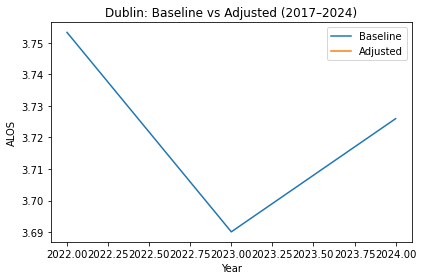

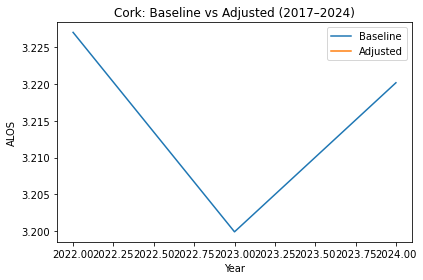

Tables saved in: Final


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


DISCHARGES_FILE   = r"Final\estimated_discharges.xlsx"
DIABETES_ALOS_FILE= r"Final\Diabetes_Alos.xlsx"
GENERAL_ALOS_FILE = r"Final\General_Alos.xlsx"

ALPHA = 0.4
REG_LAMBDA = 1.0
SAMPLE_COUNTIES = ["Dublin", "Cork"]
YEAR_MIN, YEAR_MAX = 2017, 2024

OUTDIR = Path("Final")
OUTDIR.mkdir(parents=True, exist_ok=True)

# Helper: LaTeX row writer
def df_to_tex_rows(df, float_fmt="%.2f"):
    rows = []
    for _, r in df.iterrows():
        cells = []
        for v in r:
            if isinstance(v, (float, np.floating)):
                cells.append(float_fmt % v)
            else:
                cells.append(str(v))
        rows.append(" & ".join(cells) + r" \\")
    return "\n".join(rows)


percent_non_nat = {
    "Dublin": 25.2, "Cork": 20.0, "Galway": 18.0, "Limerick": 17.0, "Waterford": 16.0,
    "Kildare": 15.0, "Meath": 14.0, "Wexford": 14.0, "Sligo": 14.0, "Clare": 13.0,
    "Tipperary": 13.0, "Kilkenny": 13.0, "Louth": 13.0, "Wicklow": 12.0, "Mayo": 12.0,
    "Kerry": 12.0, "Donegal": 12.0, "Carlow": 12.0, "Leitrim": 12.0, "Offaly": 12.0,
    "Roscommon": 12.0, "Cavan": 12.0, "Monaghan": 12.0, "Longford": 12.0, "Laois": 12.0
}
university_flag = {
    "Dublin": 1, "Cork": 1, "Galway": 1, "Limerick": 1, "Waterford": 1, "Kildare": 1, "Sligo": 1
}


dis = pd.read_excel(DISCHARGES_FILE)
dia = pd.read_excel(DIABETES_ALOS_FILE)
gen = pd.read_excel(GENERAL_ALOS_FILE)

dis = dis[(dis["Year"] >= YEAR_MIN) & (dis["Year"] <= YEAR_MAX)]
dia = dia[(dia["Year"] >= YEAR_MIN) & (dia["Year"] <= YEAR_MAX)]
gen = gen[(gen["Year"] >= YEAR_MIN) & (gen["Year"] <= YEAR_MAX)]

gen_w = pd.merge(
    gen,
    dis[["County","Year","Age Group","Sex","Estimated_Discharges"]],
    on=["County","Year","Age Group","Sex"],
    how="left"
)

def weighted_mean(g):
    vals = g["General_ALOS"].astype(float)
    w = g["Estimated_Discharges"]
    if w.notna().any() and w.fillna(0).sum() > 0:
        return np.average(vals, weights=w.fillna(0))
    else:
        return vals.mean()

group_keys = ["Year"]
if "Age Group" in gen_w.columns: group_keys.append("Age Group")
if "Sex" in gen_w.columns: group_keys.append("Sex")

G_nat = (gen_w.groupby(group_keys, as_index=False)
              .apply(lambda g: pd.Series({"G_nat": weighted_mean(g)})))

D_nat = dia.groupby(group_keys, as_index=False)["Diabetes_ALOS"].mean()

sf = pd.merge(D_nat, G_nat, on=group_keys, how="inner")
sf["SF_raw"] = sf["Diabetes_ALOS"] / sf["G_nat"]
sf["SF"] = ALPHA * sf["SF_raw"]

gen_sf = pd.merge(gen, sf[group_keys+["SF"]], on=group_keys, how="left")
gen_sf["D_hat_baseline"] = gen_sf["General_ALOS"] * gen_sf["SF"]

cnts_present = gen_sf["County"].unique().tolist()
df_proxy = pd.DataFrame({"County": cnts_present})
df_proxy["pct_non_nat"] = df_proxy["County"].map(percent_non_nat).fillna(12.0)
df_proxy["W_immig"] = df_proxy["pct_non_nat"] / df_proxy["pct_non_nat"].sum()
df_proxy["U_flag"] = df_proxy["County"].map(university_flag).fillna(0).astype(int)
df_proxy["z_W_immig"] = (df_proxy["W_immig"] - df_proxy["W_immig"].mean()) / df_proxy["W_immig"].std(ddof=0)
df_proxy["z_U_flag"] = (df_proxy["U_flag"] - df_proxy["U_flag"].mean()) / (df_proxy["U_flag"].std(ddof=0) if df_proxy["U_flag"].std(ddof=0) > 0 else 1.0)

gen_sf = pd.merge(gen_sf, df_proxy[["County","z_W_immig","z_U_flag"]], on="County", how="left")

X_cols = ["Intercept","z_W_immig","z_U_flag"]
X = pd.DataFrame({
    "Intercept": 1.0,
    "z_W_immig": gen_sf["z_W_immig"].fillna(0.0),
    "z_U_flag": gen_sf["z_U_flag"].fillna(0.0)
})
y = np.log(gen_sf["D_hat_baseline"].clip(lower=1e-6))

XtX = X.T @ X
ridge = XtX + REG_LAMBDA * np.eye(X.shape[1])
Xty = X.T @ y.values
beta = np.linalg.solve(ridge, Xty)
beta_series = pd.Series(beta, index=X_cols)

lp = X.values @ beta
gen_sf["Delta_raw"] = np.exp(lp)

def renorm(group):
    m = group["Delta_raw"].mean()
    group["Delta"] = group["Delta_raw"] / (m if m > 0 else 1.0)
    return group

gen_sf = gen_sf.groupby(group_keys, group_keys=False).apply(renorm)
gen_sf["D_hat_adjusted"] = gen_sf["D_hat_baseline"] * gen_sf["Delta"]


years_sorted = sorted(gen_sf["Year"].unique())
pick_years = sorted(set([YEAR_MIN, (YEAR_MIN+YEAR_MAX)//2, YEAR_MAX]))

tab1 = (gen_sf[(gen_sf["County"].isin(SAMPLE_COUNTIES)) & (gen_sf["Year"].isin(pick_years))]
        .groupby(["Year","County"], as_index=False)[["D_hat_baseline","D_hat_adjusted"]].mean()
        .sort_values(["Year","County"]))
tab1 = tab1.rename(columns={
    "D_hat_baseline": "Baseline Simulated ALOS",
    "D_hat_adjusted": "Adjusted Simulated ALOS"
})

with open(OUTDIR / "Table_Adj_vs_Baseline_ALOS_DublinCork_rows.tex", "w") as f:
    f.write(df_to_tex_rows(tab1, "%.2f"))

# Proxy coefficients
coef_df = pd.DataFrame({
    "Term": X_cols,
    "Estimate": beta
})
with open(OUTDIR / "Table_Proxy_Coefficients_rows.tex", "w") as f:
    f.write(df_to_tex_rows(coef_df, "%.4f"))

# Statistical summary table
stats = gen_sf.groupby("County").apply(
    lambda g: pd.Series({
        "Baseline_Mean": g["D_hat_baseline"].mean(),
        "Baseline_SD": g["D_hat_baseline"].std(),
        "Baseline_Min": g["D_hat_baseline"].min(),
        "Baseline_Max": g["D_hat_baseline"].max(),
        "Adjusted_Mean": g["D_hat_adjusted"].mean(),
        "Adjusted_SD": g["D_hat_adjusted"].std(),
        "Adjusted_Min": g["D_hat_adjusted"].min(),
        "Adjusted_Max": g["D_hat_adjusted"].max(),
        "Mean_Diff": (g["D_hat_adjusted"] - g["D_hat_baseline"]).mean(),
        "RMSE": np.sqrt(np.mean((g["D_hat_adjusted"] - g["D_hat_baseline"])**2))
    })
).reset_index()

with open(OUTDIR / "Table_ALOS_Statistics_rows.tex", "w") as f:
    f.write(df_to_tex_rows(stats.round(2), "%.2f"))


for cnt in SAMPLE_COUNTIES:
    dfc = (gen_sf[gen_sf["County"] == cnt]
           .groupby("Year", as_index=False)[["D_hat_baseline","D_hat_adjusted"]]
           .mean().sort_values("Year"))
    plt.figure()
    plt.plot(dfc["Year"], dfc["D_hat_baseline"], label="Baseline")
    plt.plot(dfc["Year"], dfc["D_hat_adjusted"], label="Adjusted")
    plt.xlabel("Year"); plt.ylabel("ALOS")
    plt.title(f"{cnt}: Baseline vs Adjusted (2017–2024)")
    plt.legend(); plt.tight_layout()
    plt.show()

print("Tables saved in:", OUTDIR)


In [12]:
import pandas as pd
import numpy as np


alpha = 0.4
beta_0 = 0.0       # intercept
beta_1 = 0.02      # immigration effect
beta_2 = 0.05      # university effect
beta_3 = 0.015     #Co-morbidity effect

# Proxy immigration % (non-nationals) and university presence
immigration_data = {
    "Dublin": 25.2, "Cork": 20.0, "Galway": 18.0, "Limerick": 17.0,
    "Waterford": 16.0, "Kildare": 15.0, "Meath": 14.0, "Wexford": 14.0,
    "Sligo": 14.0, "Clare": 13.0, "Tipperary": 13.0, "Kilkenny": 13.0,
    "Louth": 13.0, "Wicklow": 12.0, "Mayo": 12.0, "Kerry": 12.0,
    "Donegal": 12.0, "Carlow": 12.0, "Leitrim": 12.0, "Offaly": 12.0,
    "Roscommon": 12.0, "Cavan": 12.0, "Monaghan": 12.0, "Longford": 12.0,
    "Laois": 12.0
}
university_data = {
    "Dublin": 1, "Cork": 1, "Galway": 1, "Limerick": 1,
    "Waterford": 1, "Kildare": 1, "Sligo": 1
}


# Should have columns: County, Year, Age Group, Sex, General_ALOS, Diabetes_ALOS, Scaling_Factor, Simulated_Diabetes_ALOS
df = pd.read_excel("Final/simulated_los_data.xlsx")

# Rename for clarity
df.rename(columns={"Simulated_Diabetes_ALOS": "Baseline_ALOS"}, inplace=True)


df["Immigration_Pct"] = df["County"].map(immigration_data).fillna(12.0)
df["University"] = df["County"].map(university_data).fillna(0)


df["Adjustment_Factor"] = np.exp(beta_0 + beta_1 * df["Immigration_Pct"] + beta_2 * df["University"])
df["Adjusted_ALOS"] = df["Baseline_ALOS"] * df["Adjustment_Factor"]


df = df[(df["Year"] >= 2017) & (df["Year"] <= 2024)]


def rmse(x, y):
    return np.sqrt(np.mean((x - y) ** 2))

stats = df.groupby("County").apply(
    lambda g: pd.Series({
        "Baseline_Mean": g["Baseline_ALOS"].mean(),
        "Baseline_SD": g["Baseline_ALOS"].std(),
        "Baseline_Min": g["Baseline_ALOS"].min(),
        "Baseline_Max": g["Baseline_ALOS"].max(),
        "Adjusted_Mean": g["Adjusted_ALOS"].mean(),
        "Adjusted_SD": g["Adjusted_ALOS"].std(),
        "Adjusted_Min": g["Adjusted_ALOS"].min(),
        "Adjusted_Max": g["Adjusted_ALOS"].max(),
        "Mean_Diff": (g["Adjusted_ALOS"] - g["Baseline_ALOS"]).mean(),
        "RMSE": rmse(g["Adjusted_ALOS"], g["Baseline_ALOS"])
    })
).reset_index()

# Ranking columns
stats["Rank_AdjustedMean"] = stats["Adjusted_Mean"].rank(ascending=False, method="min").astype(int)
stats["Rank_RMSE"] = stats["RMSE"].rank(ascending=False, method="min").astype(int)


def df_to_tex_rows(df, float_fmt="%.2f"):
    tex = ""
    for _, row in df.iterrows():
        tex += " & ".join(
            [str(row["County"])] +
            [float_fmt % val if isinstance(val, (int, float, np.floating)) else str(val)
             for val in row.drop("County")]
        ) + r" \\" + "\n"
    return tex

# Save ranked statistics table
with open("Final/Table_ALOS_Statistics_Ranked_rows.tex", "w") as f:
    f.write(df_to_tex_rows(stats.round(2), "%.2f"))

# Also save sample counties table (Dublin, Cork)
sample_df = df[df["County"].isin(["Dublin", "Cork"])]
sample_table = sample_df.groupby(["County", "Year"]).agg(
    Baseline_Mean=("Baseline_ALOS", "mean"),
    Adjusted_Mean=("Adjusted_ALOS", "mean")
).reset_index()
with open("Final/Table_Dublin_Cork_ALOS.tex", "w") as f:
    f.write(df_to_tex_rows(sample_table.round(2), "%.2f"))

print("Tables saved to Final/ folder.")


Tables saved to Final/ folder.



=== Dublin & Cork (Baseline vs Adjusted ALOS, by year) ===


,County,Year,Baseline_ALOS,Adjusted_ALOS
0,Cork,2017,NaN,NaN
1,Cork,2018,NaN,NaN
2,Cork,2019,NaN,NaN
3,Cork,2020,NaN,NaN
4,Cork,2021,NaN,NaN
5,Cork,2022,3.23,3.77
6,Cork,2023,3.20,3.74
7,Cork,2024,3.22,3.76
8,Dublin,2017,NaN,NaN
9,Dublin,2018,NaN,NaN



=== Ranked ALOS Statistics (2017–2024) ===


,County,Baseline Mean,Baseline SD,Baseline Min,Baseline Max,Adjusted Mean,Adjusted SD,Adjusted Min,Adjusted Max,Mean Diff,RMSE,Rank Adj. Mean,Rank RMSE
0,Carlow,3.10,1.72,0.79,6.33,2.94,1.62,0.75,5.99,-0.17,0.19,11,9
1,Cavan,2.85,1.49,0.75,5.84,2.70,1.41,0.71,5.53,-0.15,0.17,22,17
2,Clare,2.79,1.34,0.96,5.71,2.69,1.30,0.93,5.51,-0.10,0.11,23,24
3,Cork,3.22,1.85,0.90,7.87,3.76,2.16,1.05,9.19,0.54,0.62,2,2
4,Donegal,3.00,1.59,1.13,6.86,2.84,1.51,1.07,6.49,-0.16,0.18,16,11
5,Dublin,3.72,2.37,1.16,9.96,4.83,3.07,1.50,12.91,1.10,1.30,1,1
6,Galway,3.21,1.96,0.94,7.92,3.60,2.20,1.06,8.89,0.39,0.46,3,3
7,Kerry,3.00,1.60,0.97,6.80,2.84,1.52,0.92,6.44,-0.16,0.18,17,12
8,Kildare,2.95,1.75,0.85,7.32,3.11,1.84,0.90,7.74,0.17,0.19,7,7
9,Kilkenny,3.12,1.67,1.05,7.27,3.01,1.62,1.02,7.02,-0.11,0.12,8,20


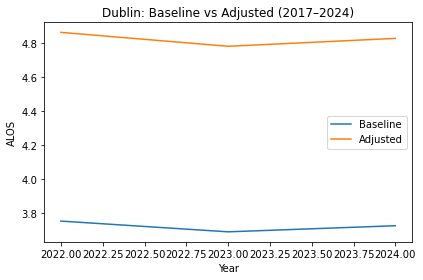

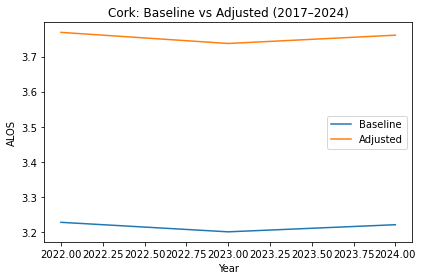

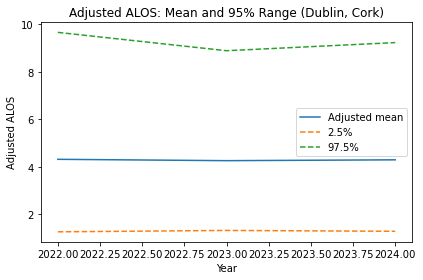


Outputs saved in: C:\Users\DINESH\Downloads\Thesis\Final\_county_adjusted_reset
 - Table_DublinCork_ByYear_rows.tex
 - Table_Stats_Ranked_rows.tex
 - Fig_<County>_Baseline_vs_Adjusted.png
 - Fig_MeanAdjusted_95pct.png


In [13]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


FILES = {
    "discharges": r"Final\estimated_discharges.xlsx",  # County, Year, Age Group, Sex, Estimated_Discharges
    "diab_alos":  r"Final\Diabetes_Alos.xlsx",         # Year, Age Group, Sex, Diabetes_ALOS  (national)
    "gen_alos":   r"Final\General_Alos.xlsx",          # County, Year, Age Group, Sex, General_ALOS (county)
}
YEARS = (2017, 2024)
ALPHA = 0.4
SHOW_COUNTIES = ["Dublin", "Cork"]   # change if needed

# Proxy assumptions (edit if desired)
IMMIGRATION_PCT = {
    "Dublin": 25.2, "Cork": 20.0, "Galway": 18.0, "Limerick": 17.0, "Waterford": 16.0,
    "Kildare": 15.0, "Meath": 14.0, "Wexford": 14.0, "Sligo": 14.0, "Clare": 13.0,
    "Tipperary": 13.0, "Kilkenny": 13.0, "Louth": 13.0, "Wicklow": 12.0, "Mayo": 12.0,
    "Kerry": 12.0, "Donegal": 12.0, "Carlow": 12.0, "Leitrim": 12.0, "Offaly": 12.0,
    "Roscommon": 12.0, "Cavan": 12.0, "Monaghan": 12.0, "Longford": 12.0, "Laois": 12.0
}
UNIVERSITY_FLAG = {
    "Dublin": 1, "Cork": 1, "Galway": 1, "Limerick": 1, "Waterford": 1, "Kildare": 1, "Sligo": 1
}

# Simple fixed coefficients (transparent worked example)
BETA0, BETA1, BETA2 = 0.0, 0.02, 0.05

OUTDIR = Path("Final/_county_adjusted_reset")
OUTDIR.mkdir(parents=True, exist_ok=True)


def df_to_tex_rows(df, float_fmt="%.2f"):
    rows = []
    for _, r in df.iterrows():
        cells = []
        for v in r:
            if isinstance(v, (float, int, np.floating, np.integer)) and pd.notna(v):
                cells.append(float_fmt % float(v))
            else:
                cells.append("" if pd.isna(v) else str(v))
        rows.append(" & ".join(cells) + r" \\")
    return "\n".join(rows)

def weighted_mean(vals, w):
    if w.notna().any() and w.fillna(0).sum() > 0:
        return float(np.average(vals.astype(float), weights=w.fillna(0)))
    return float(vals.astype(float).mean())

def rmse(a, b):
    a, b = pd.to_numeric(a, errors="coerce"), pd.to_numeric(b, errors="coerce")
    m = a.notna() & b.notna()
    return float(np.sqrt(np.mean((a[m]-b[m])**2))) if m.any() else np.nan


dis = pd.read_excel(FILES["discharges"])
dia = pd.read_excel(FILES["diab_alos"])
gen = pd.read_excel(FILES["gen_alos"])

ymin, ymax = YEARS
dis = dis[(dis["Year"]>=ymin) & (dis["Year"]<=ymax)].copy()
dia = dia[(dia["Year"]>=ymin) & (dia["Year"]<=ymax)].copy()
gen = gen[(gen["Year"]>=ymin) & (gen["Year"]<=ymax)].copy()


# Weighted national general ALOS by Estimated_Discharges if present
genw = gen.merge(
    dis[["County","Year","Age Group","Sex","Estimated_Discharges"]],
    on=["County","Year","Age Group","Sex"], how="left"
)

group_keys = ["Year"]
if "Age Group" in genw.columns: group_keys.append("Age Group")
if "Sex" in genw.columns: group_keys.append("Sex")

Gnat = (genw.groupby(group_keys)
        .apply(lambda g: pd.Series({"G_nat": weighted_mean(g["General_ALOS"], g["Estimated_Discharges"])}))
        .reset_index())

Dnat = dia.groupby(group_keys, as_index=False)["Diabetes_ALOS"].mean()

sf = pd.merge(Dnat, Gnat, on=group_keys, how="inner")
sf["SF_raw"] = sf["Diabetes_ALOS"] / sf["G_nat"]
sf["SF"] = ALPHA * sf["SF_raw"]

# attach SF to county rows
df = gen.merge(sf[group_keys+["SF"]], on=group_keys, how="left")
df["Baseline_ALOS"] = df["General_ALOS"] * df["SF"]


df["Immigration_Pct"] = df["County"].map(IMMIGRATION_PCT).fillna(12.0)
df["University"] = df["County"].map(UNIVERSITY_FLAG).fillna(0).astype(int)

# raw multiplier
df["Delta_raw"] = np.exp(BETA0 + BETA1*df["Immigration_Pct"] + BETA2*df["University"])

# RENORMALIZE per (Year, Age, Sex): mean(Delta)=1 so totals don’t drift
def renorm(group):
    m = group["Delta_raw"].mean()
    group["Delta"] = group["Delta_raw"] / (m if m>0 else 1.0)
    return group

df = df.groupby(group_keys, group_keys=False).apply(renorm)
df["Adjusted_ALOS"] = df["Baseline_ALOS"] * df["Delta"]


sample = (df[df["County"].isin(SHOW_COUNTIES)]
          .groupby(["County","Year"], as_index=False)[["Baseline_ALOS","Adjusted_ALOS"]]
          .mean(numeric_only=True)
          .sort_values(["County","Year"]))

with open(OUTDIR / "Table_DublinCork_ByYear_rows.tex","w",encoding="utf-8") as f:
    f.write(df_to_tex_rows(sample.round(2), "%.2f"))

print("\n=== Dublin & Cork (Baseline vs Adjusted ALOS, by year) ===")
try:
    from IPython.display import display
    display(sample.round(2))
except Exception:
    print(sample.round(2).to_string(index=False))


stats = (df.groupby("County")
         .apply(lambda g: pd.Series({
             "Baseline Mean": g["Baseline_ALOS"].mean(),
             "Baseline SD":   g["Baseline_ALOS"].std(),
             "Baseline Min":  g["Baseline_ALOS"].min(),
             "Baseline Max":  g["Baseline_ALOS"].max(),
             "Adjusted Mean": g["Adjusted_ALOS"].mean(),
             "Adjusted SD":   g["Adjusted_ALOS"].std(),
             "Adjusted Min":  g["Adjusted_ALOS"].min(),
             "Adjusted Max":  g["Adjusted_ALOS"].max(),
             "Mean Diff":     (g["Adjusted_ALOS"] - g["Baseline_ALOS"]).mean(),
             "RMSE":          rmse(g["Adjusted_ALOS"], g["Baseline_ALOS"]),
         }))
         .reset_index())

# ranks
stats["Rank Adj. Mean"] = stats["Adjusted Mean"].rank(ascending=False, method="min").astype("Int64")
stats["Rank RMSE"]      = stats["RMSE"].rank(ascending=False, method="min").astype("Int64")
stats_out = stats.round(2)

with open(OUTDIR / "Table_Stats_Ranked_rows.tex","w",encoding="utf-8") as f:
    f.write(df_to_tex_rows(stats_out[[
        "County","Baseline Mean","Baseline SD","Baseline Min","Baseline Max",
        "Adjusted Mean","Adjusted SD","Adjusted Min","Adjusted Max",
        "Mean Diff","RMSE","Rank Adj. Mean","Rank RMSE"
    ]], "%.2f"))

print("\n=== Ranked ALOS Statistics (2017–2024) ===")
try:
    from IPython.display import display
    display(stats_out)
except Exception:
    print(stats_out.to_string(index=False))

# Also save CSV/XLSX for sanity checks
stats_out.to_csv(OUTDIR / "ALOS_Stats_Ranked.csv", index=False)
sample.round(2).to_csv(OUTDIR / "DublinCork_ByYear.csv", index=False)


for cnt in SHOW_COUNTIES:
    series = (df[df["County"]==cnt]
              .groupby("Year", as_index=False)[["Baseline_ALOS","Adjusted_ALOS"]]
              .mean().sort_values("Year"))
    plt.figure()
    plt.plot(series["Year"], series["Baseline_ALOS"], label="Baseline")
    plt.plot(series["Year"], series["Adjusted_ALOS"], label="Adjusted")
    plt.xlabel("Year"); plt.ylabel("ALOS")
    plt.title(f"{cnt}: Baseline vs Adjusted (2017–2024)")
    plt.legend(); plt.tight_layout()
    plt.savefig(OUTDIR / f"Fig_{cnt}_Baseline_vs_Adjusted.png", dpi=300)
    plt.show()

# Mean adjusted across showcase counties (with 2.5/97.5 pct bands)
sub = df[df["County"].isin(SHOW_COUNTIES)]
mean_adj = sub.groupby("Year")["Adjusted_ALOS"].mean().reset_index()
lo = sub.groupby("Year")["Adjusted_ALOS"].quantile(0.025).reset_index()
hi = sub.groupby("Year")["Adjusted_ALOS"].quantile(0.975).reset_index()

plt.figure()
plt.plot(mean_adj["Year"], mean_adj["Adjusted_ALOS"], label="Adjusted mean")
plt.plot(lo["Year"], lo["Adjusted_ALOS"], linestyle="--", label="2.5%")
plt.plot(hi["Year"], hi["Adjusted_ALOS"], linestyle="--", label="97.5%")
plt.xlabel("Year"); plt.ylabel("Adjusted ALOS")
plt.title(f"Adjusted ALOS: Mean and 95% Range ({', '.join(SHOW_COUNTIES)})")
plt.legend(); plt.tight_layout()
plt.savefig(OUTDIR / "Fig_MeanAdjusted_95pct.png", dpi=300)
plt.show()

print(f"\nOutputs saved in: {OUTDIR.resolve()}")
print(" - Table_DublinCork_ByYear_rows.tex")
print(" - Table_Stats_Ranked_rows.tex")
print(" - Fig_<County>_Baseline_vs_Adjusted.png")
print(" - Fig_MeanAdjusted_95pct.png")


In [24]:

import pandas as pd
import numpy as np
from pathlib import Path


BASELINE_PATH = Path("Final/simulated_los_data.xlsx")          
IMMIG_PATH    = Path("Final/Immigration_By_County.xlsx")        # columns: County, Year, Immigrant_Share
UNIV_PATH     = Path("Final/Universities_By_County.xlsx")       # columns: County, Year, Univ_Weight
AGE65_PATH    = Path("Final/Ageing_By_County.xlsx")             # columns: County, Year, Age65Plus_Share

# Normalization of covariates within each Year: "zscore" or "minmax"
NORMALIZE = "zscore"

# Coefficients (betas) on standardized covariates 
BETA_IMMIG = 0.40
BETA_UNIV  = 0.30
BETA_AGE65 = 0.30

# Optional age/sex fixed effects (γ_a, δ_s). Leave empty to treat as 0.
AGE_EFFECTS = {
    # "0 - 14 years": 0.0,
    # "15 - 24 years": 0.0,
    # ...
}
SEX_EFFECTS = {
    # "Male": 0.0,
    # "Female": 0.0,
}


LOWER_BOUND = 0.70
UPPER_BOUND = 1.40


CENTERING = "year"

# Outputs
OUT_DATA_PATH   = Path("Final/simulated_los_data_adjusted.xlsx")
OUT_SUMMARY_XLS = Path("Final/county_adjuster_summary.xlsx")


def require_cols(df, cols, name):
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise ValueError(f"Missing columns in {name}: {missing}")

df = pd.read_excel(BASELINE_PATH)
require_cols(df, ["County","Year","Age Group","Sex","General_ALOS","Scaling_Factor"], "baseline")

imm = pd.read_excel(IMMIG_PATH)
require_cols(imm, ["County","Year","Immigrant_Share"], "immigration")

unv = pd.read_excel(UNIV_PATH)
require_cols(unv, ["County","Year","Univ_Weight"], "universities")

age = pd.read_excel(AGE65_PATH)
require_cols(age, ["County","Year","Age65Plus_Share"], "ageing")

# Standardize keys
for t in (df, imm, unv, age):
    t["County"] = t["County"].astype(str).str.strip()
    t["Year"]   = t["Year"].astype(int)


def zscore_by_year(tbl, col):
    tbl = tbl.copy()
    def z(g):
        sd = g.std(ddof=0)
        return (g - g.mean())/sd if (sd is not None and np.isfinite(sd) and sd > 0) else 0.0
    tbl[f"norm_{col}"] = tbl.groupby("Year")[col].transform(z).fillna(0.0)
    return tbl

def minmax_by_year(tbl, col):
    tbl = tbl.copy()
    def mm(g):
        lo, hi = g.min(), g.max()
        return (g - lo)/(hi - lo) if (pd.notnull(hi) and pd.notnull(lo) and hi > lo) else 0.0
    tbl[f"norm_{col}"] = tbl.groupby("Year")[col].transform(mm).fillna(0.0)
    return tbl

norm = zscore_by_year if NORMALIZE == "zscore" else minmax_by_year

imm  = norm(imm, "Immigrant_Share")
unv  = norm(unv, "Univ_Weight")
age  = norm(age, "Age65Plus_Share")


Z = (imm[["County","Year","norm_Immigrant_Share"]]
     .merge(unv[["County","Year","norm_Univ_Weight"]], on=["County","Year"], how="outer")
     .merge(age[["County","Year","norm_Age65Plus_Share"]], on=["County","Year"], how="outer"))

for col in ["norm_Immigrant_Share","norm_Univ_Weight","norm_Age65Plus_Share"]:
    Z[col] = Z[col].fillna(0.0)

coef_map = {
    "norm_Immigrant_Share": BETA_IMMIG,
    "norm_Univ_Weight":     BETA_UNIV,
    "norm_Age65Plus_Share": BETA_AGE65,
}

Z["linpred"] = (
    coef_map["norm_Immigrant_Share"] * Z["norm_Immigrant_Share"] +
    coef_map["norm_Univ_Weight"]     * Z["norm_Univ_Weight"] +
    coef_map["norm_Age65Plus_Share"] * Z["norm_Age65Plus_Share"]
)


df = df.merge(Z[["County","Year","linpred"]], on=["County","Year"], how="left")
df["linpred"] = df["linpred"].fillna(0.0)

# Add γ_a and δ_s (0 if not provided)
df["gamma_a"] = df["Age Group"].map(AGE_EFFECTS).fillna(0.0)
df["delta_s"] = df["Sex"].map(SEX_EFFECTS).fillna(0.0)

df["lp_no_intercept"] = df["linpred"] + df["gamma_a"] + df["delta_s"]

if CENTERING == "year_age_sex":
    grp = ["Year","Age Group","Sex"]
else:
    grp = ["Year"]

mean_exp = df.groupby(grp)["lp_no_intercept"].transform(lambda x: np.exp(x).mean())
beta0_by_row = -np.log(mean_exp.replace(0, np.nan)).fillna(0.0)

df["Delta"] = np.exp(beta0_by_row + df["lp_no_intercept"])
df["Delta"] = df["Delta"].clip(lower=LOWER_BOUND, upper=UPPER_BOUND)

df["Scaling_Factor_Adj"] = df["Scaling_Factor"] * df["Delta"]
df["Diabetes_ALOS_Adj"]  = df["General_ALOS"] * df["Scaling_Factor_Adj"]

if "Estimated_Discharges" in df.columns:
    df["Estimated_Diabetes_Bed_Days_Adj"] = df["Estimated_Discharges"] * df["Diabetes_ALOS_Adj"]

# ALOS: keep one decimal; counts: Int64
for col in ["General_ALOS","Diabetes_ALOS_Adj"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce").round(1)

for col in ["Estimated_Discharges","Estimated_Diabetes_Bed_Days_Adj"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce").round().astype("Int64")

# Save adjusted dataset
OUT_DATA_PATH.parent.mkdir(parents=True, exist_ok=True)
df.to_excel(OUT_DATA_PATH, index=False)

# 1) Delta by County-Year (mean across strata)
delta_cy = (df.groupby(["County","Year"], as_index=False)["Delta"]
              .mean()
              .rename(columns={"Delta":"Delta_Mean"}))

# 2) Covariate norms by County-Year (for reporting)
cov_norms = Z.rename(columns={
    "norm_Immigrant_Share": "Immig_norm",
    "norm_Univ_Weight":     "Univ_norm",
    "norm_Age65Plus_Share": "Age65_norm"
})[["County","Year","Immig_norm","Univ_norm","Age65_norm"]]

# 3) Check centering actually preserved mean Δ
if CENTERING == "year_age_sex":
    centering_check = (df.groupby(["Year","Age Group","Sex"])["Delta"]
                         .mean()
                         .reset_index()
                         .rename(columns={"Delta":"Mean_Delta"}))
else:
    centering_check = (df.groupby(["Year"])["Delta"]
                         .mean()
                         .reset_index()
                         .rename(columns={"Delta":"Mean_Delta"}))

with pd.ExcelWriter(OUT_SUMMARY_XLS) as xw:
    delta_cy.to_excel(xw, sheet_name="Delta_By_County_Year", index=False)
    cov_norms.to_excel(xw, sheet_name="Covariate_Norms", index=False)
    centering_check.to_excel(xw, sheet_name="Centering_Check", index=False)

print(f"Saved adjusted data -> {OUT_DATA_PATH}")
print(f"Saved summaries     -> {OUT_SUMMARY_XLS}")


Saved adjusted data -> Final\simulated_los_data_adjusted.xlsx
Saved summaries     -> Final\county_adjuster_summary.xlsx


In [26]:
import pandas as pd
import numpy as np
from pathlib import Path


BASELINE_PATH = Path("Final/simulated_los_data.xlsx")           # must include: County, Year, Age Group, Sex, General_ALOS, Scaling_Factor
IMMIG_PATH    = Path("Final/Immigration_By_County.xlsx")        # County, Year, Immigrant_Share
UNIV_PATH     = Path("Final/Universities_By_County.xlsx")       # County, Year, Univ_Weight
AGE65_PATH    = Path("Final/Ageing_By_County.xlsx")             # County, Year, Age65Plus_Share

# Standardize covariates within each Year: "zscore" or "minmax"
NORMALIZE = "zscore"

# β coefficients on standardized covariates (Immigration, University, Ageing)
BETA_IMMIG = 0.40
BETA_UNIV  = 0.30
BETA_AGE65 = 0.30

# Optional fixed effects (γ_a, δ_s). Leave empty to set 0 for all groups.
AGE_EFFECTS = {
    # "0 - 14 years": 0.0,
    # "15 - 24 years": 0.0,
}
SEX_EFFECTS = {
    # "Male": 0.0,
    # "Female": 0.0,
}

# Stabilize Δ (Eq. [box-constraints]): 0 < ℓ < 1 < u
LOWER_BOUND_DELTA = 0.70
UPPER_BOUND_DELTA = 1.40

# Centering target for mean(Δ)=1:
# "year"           -> preserve annual national level
# "year_age_sex"   -> preserve within each (Year, Age Group, Sex)
CENTERING = "year"

# ALOS sanity clamp (days) + flag
ALOS_MIN = 0.5
ALOS_MAX = 60.0

# Outputs
OUT_DATA_PATH   = Path("Final/simulated_los_data_adjusted.xlsx")
OUT_SUMMARY_XLS = Path("Final/county_adjuster_summary.xlsx")


def require_cols(df, cols, name):
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise ValueError(f"Missing columns in {name}: {missing}")

def zscore_by_year(tbl, col):
    tbl = tbl.copy()
    def z(g):
        sd = g.std(ddof=0)
        return (g - g.mean())/sd if (pd.notnull(sd) and sd > 0) else 0.0
    tbl[f"norm_{col}"] = tbl.groupby("Year")[col].transform(z).fillna(0.0)
    return tbl

def minmax_by_year(tbl, col):
    tbl = tbl.copy()
    def mm(g):
        lo, hi = g.min(), g.max()
        return (g - lo)/(hi - lo) if (pd.notnull(hi) and pd.notnull(lo) and hi > lo) else 0.0
    tbl[f"norm_{col}"] = tbl.groupby("Year")[col].transform(mm).fillna(0.0)
    return tbl


df   = pd.read_excel(BASELINE_PATH)
imm  = pd.read_excel(IMMIG_PATH)
unv  = pd.read_excel(UNIV_PATH)
age  = pd.read_excel(AGE65_PATH)

require_cols(df,  ["County","Year","Age Group","Sex","General_ALOS","Scaling_Factor"], "baseline")
require_cols(imm, ["County","Year","Immigrant_Share"], "immigration")
require_cols(unv, ["County","Year","Univ_Weight"], "universities")
require_cols(age, ["County","Year","Age65Plus_Share"], "ageing")

for t in (df, imm, unv, age):
    t["County"] = t["County"].astype(str).str.strip()
    t["Year"]   = t["Year"].astype(int)


norm = zscore_by_year if NORMALIZE == "zscore" else minmax_by_year
imm  = norm(imm, "Immigrant_Share")
unv  = norm(unv, "Univ_Weight")
age  = norm(age, "Age65Plus_Share")

Z = (imm[["County","Year","norm_Immigrant_Share"]]
     .merge(unv[["County","Year","norm_Univ_Weight"]], on=["County","Year"], how="outer")
     .merge(age[["County","Year","norm_Age65Plus_Share"]], on=["County","Year"], how="outer"))

for col in ["norm_Immigrant_Share","norm_Univ_Weight","norm_Age65Plus_Share"]:
    Z[col] = Z[col].fillna(0.0)

# Linear predictor without intercept: β'Z
coef_map = {
    "norm_Immigrant_Share": BETA_IMMIG,
    "norm_Univ_Weight":     BETA_UNIV,
    "norm_Age65Plus_Share": BETA_AGE65,
}
Z["linpred"] = (
    coef_map["norm_Immigrant_Share"] * Z["norm_Immigrant_Share"] +
    coef_map["norm_Univ_Weight"]     * Z["norm_Univ_Weight"] +
    coef_map["norm_Age65Plus_Share"] * Z["norm_Age65Plus_Share"]
)

# Merge with baseline panel + add γ_a, δ_s
df = df.merge(Z[["County","Year","linpred"]], on=["County","Year"], how="left")
df["linpred"] = df["linpred"].fillna(0.0)
df["gamma_a"] = df["Age Group"].map(AGE_EFFECTS).fillna(0.0)
df["delta_s"] = df["Sex"].map(SEX_EFFECTS).fillna(0.0)
df["lp_no_intercept"] = df["linpred"] + df["gamma_a"] + df["delta_s"]

# β0 centering so mean(Δ)=1, then clamp Δ

grp = ["Year","Age Group","Sex"] if CENTERING == "year_age_sex" else ["Year"]
mean_exp = df.groupby(grp)["lp_no_intercept"].transform(lambda x: np.exp(x).mean())
beta0 = -np.log(mean_exp.replace(0, np.nan)).fillna(0.0)

df["Delta"] = np.exp(beta0 + df["lp_no_intercept"])
df["Delta"] = df["Delta"].clip(lower=LOWER_BOUND_DELTA, upper=UPPER_BOUND_DELTA)


df["Scaling_Factor_Adj"] = df["Scaling_Factor"] * df["Delta"]
df["Diabetes_ALOS_Adj"]  = df["General_ALOS"] * df["Scaling_Factor_Adj"]

# ALOS sanity clamp + flag
df["ALOS_Flag_Implausible"] = ((df["Diabetes_ALOS_Adj"] < ALOS_MIN) | (df["Diabetes_ALOS_Adj"] > ALOS_MAX)).astype(int)
df["Diabetes_ALOS_Adj"] = df["Diabetes_ALOS_Adj"].clip(lower=ALOS_MIN, upper=ALOS_MAX)

# Formatting: ALOS to 1 decimal, keep discharges if present
for col in ["General_ALOS","Diabetes_ALOS_Adj"]:
    df[col] = pd.to_numeric(df[col], errors="coerce").round(1)
if "Estimated_Discharges" in df.columns:
    df["Estimated_Discharges"] = pd.to_numeric(df["Estimated_Discharges"], errors="coerce").round().astype("Int64")


OUT_DATA_PATH.parent.mkdir(parents=True, exist_ok=True)
df.to_excel(OUT_DATA_PATH, index=False)


delta_cy = (df.groupby(["County","Year"], as_index=False)["Delta"]
              .mean()
              .rename(columns={"Delta":"Delta_Mean"}))

cov_norms = Z.rename(columns={
    "norm_Immigrant_Share": "Immig_norm",
    "norm_Univ_Weight":     "Univ_norm",
    "norm_Age65Plus_Share": "Age65_norm"
})[["County","Year","Immig_norm","Univ_norm","Age65_norm"]]

centering_check = (df.groupby(grp)["Delta"]
                     .mean()
                     .reset_index()
                     .rename(columns={"Delta":"Mean_Delta"}))

alos_qc = (df[df["ALOS_Flag_Implausible"] == 1]
           .loc[:, ["County","Year","Age Group","Sex","General_ALOS","Scaling_Factor","Delta","Diabetes_ALOS_Adj","ALOS_Flag_Implausible"]]
           .sort_values(["Year","County","Age Group","Sex"]))

with pd.ExcelWriter(OUT_SUMMARY_XLS) as xw:
    delta_cy.to_excel(xw, sheet_name="Delta_By_County_Year", index=False)
    cov_norms.to_excel(xw, sheet_name="Covariate_Norms", index=False)
    centering_check.to_excel(xw, sheet_name="Centering_Check", index=False)
    alos_qc.to_excel(xw, sheet_name="ALOS_Clamped_Rows", index=False)

print(f"Saved adjusted data   -> {OUT_DATA_PATH}")
print(f"Saved diagnostics     -> {OUT_SUMMARY_XLS}")



Saved adjusted data   -> Final\simulated_los_data_adjusted.xlsx
Saved diagnostics     -> Final\county_adjuster_summary.xlsx


In [29]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from textwrap import dedent


ROOT = Path("Final")              # input & output root
BASELINE_FP = ROOT / "simulated_los_data.xlsx"
POP_FP      = ROOT / "Estimated_Population.xlsx"

# Proxy covariate outputs
IMM_FP   = ROOT / "Immigration_By_County.xlsx"
UNIV_FP  = ROOT / "Universities_By_County.xlsx"
AGE65_FP = ROOT / "Ageing_By_County.xlsx"

# Adjusted outputs
ADJ_FP        = ROOT / "simulated_los_data_adjusted.xlsx"
SUMMARY_XLSX  = ROOT / "worked_example_summary_table.xlsx"
SNIPPET_TEX   = ROOT / "worked_example_snippet.tex"

# Figures
FIG_DIR = ROOT / "worked_example_figs"
FIG1 = FIG_DIR / "fig1_diab_alos_ci.png"
FIG2 = FIG_DIR / "fig2_general_alos_ci.png"
FIG3 = FIG_DIR / "fig3_ratio.png"
FIG_PANEL = FIG_DIR / "fig_panel_abc.png"

# Model knobs
NORMALIZE = "zscore"          # "zscore" or "minmax"
BETA_IMMIG = 0.40
BETA_UNIV  = 0.30
BETA_AGE65 = 0.30
LOWER_BOUND_DELTA = 0.70
UPPER_BOUND_DELTA = 1.40
CENTERING = "year"            # "year" or "year_age_sex"
ALOS_MIN, ALOS_MAX = 0.5, 60.0
VERTICAL_MARKER = 2020        # vertical line (set None to disable)


def require_cols(df, cols, name):
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise ValueError(f"Missing columns in {name}: {missing}")

def zscore_by_year(tbl, col):
    tbl = tbl.copy()
    def z(g):
        sd = g.std(ddof=0)
        return (g - g.mean())/sd if (pd.notnull(sd) and sd > 0) else 0.0
    tbl[f"norm_{col}"] = tbl.groupby("Year")[col].transform(z).fillna(0.0)
    return tbl

def minmax_by_year(tbl, col):
    tbl = tbl.copy()
    def mm(g):
        lo, hi = g.min(), g.max()
        return (g - lo)/(hi - lo) if (pd.notnull(hi) and pd.notnull(lo) and hi > lo) else 0.0
    tbl[f"norm_{col}"] = tbl.groupby("Year")[col].transform(mm).fillna(0.0)
    return tbl

def normalize(tbl, col, how):
    return zscore_by_year(tbl, col) if how == "zscore" else minmax_by_year(tbl, col)

def wmean(group, col, weight_col=None):
    v = group[col].astype(float)
    if weight_col and weight_col in group.columns:
        w = group[weight_col].astype(float).fillna(0.0)
        s = w.sum()
        return (w*v).sum()/s if s > 0 else v.mean()
    return v.mean()

ROOT.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

baseline = pd.read_excel(BASELINE_FP)
require_cols(baseline, ["County","Year","Age Group","Sex","General_ALOS","Scaling_Factor"], "baseline")

pop = pd.read_excel(POP_FP)
require_cols(pop, ["County","Year","Sex","Age Group","Estimated_Population"], "Estimated_Population")

# standardize keys
for t in (baseline, pop):
    t["County"] = t["County"].astype(str).str.strip()
    t["Year"]   = t["Year"].astype(int)


# total pop
total_pop = pop.groupby(["County","Year"], as_index=False)["Estimated_Population"].sum()

# ageing share (65+)
age_mask = pop["Age Group"].astype(str).str.contains("65", case=False)
age65 = (pop[age_mask]
         .groupby(["County","Year"], as_index=False)["Estimated_Population"].sum()
         .rename(columns={"Estimated_Population":"Age65Plus"})
         .merge(total_pop, on=["County","Year"]))
age65["Age65Plus_Share"] = age65["Age65Plus"] / age65["Estimated_Population"]
age_df = age65[["County","Year","Age65Plus_Share"]]

# immigration share proxy – use a plausible fixed spatial pattern + national trend
base_immig_pattern = {
    "Dublin": 0.20, "Cork": 0.12, "Galway": 0.11, "Limerick": 0.10,
    "Waterford": 0.09, "Kildare": 0.08, "Meath": 0.08, "Wicklow": 0.07,
    "Louth": 0.07, "Westmeath": 0.06, "Clare": 0.06, "Kerry": 0.05,
    "Tipperary": 0.05, "Kilkenny": 0.05, "Laois": 0.05, "Offaly": 0.05,
    "Carlow": 0.04, "Cavan": 0.04, "Monaghan": 0.04, "Mayo": 0.03,
    "Roscommon": 0.03, "Sligo": 0.03, "Leitrim": 0.03, "Longford": 0.03,
    "Donegal": 0.03
}
# normalize pattern to sum 1
pattern_sum = sum(base_immig_pattern.values())
base_immig_pattern = {k: v/pattern_sum for k, v in base_immig_pattern.items()}

years = sorted(total_pop["Year"].unique())
# national immigrant share trend (proxy): 0.125 -> 0.145
nat_rates = np.linspace(0.125, 0.145, len(years))

imm_rows = []
for y, nat in zip(years, nat_rates):
    # scale county shares so the sum across counties ≈ nat
    scale = len(base_immig_pattern)  # back out normalization choice
    for _, r in total_pop[total_pop["Year"] == y].iterrows():
        cty = r["County"]
        cshare = base_immig_pattern.get(cty, np.mean(list(base_immig_pattern.values())))
        imm_rows.append([cty, y, nat * cshare * scale])
imm_df = pd.DataFrame(imm_rows, columns=["County","Year","Immigrant_Share"])

# university weight proxy (students / county pop)
university_counties = {
    "Dublin": 80000, "Cork": 25000, "Galway": 20000, "Limerick": 18000,
    "Maynooth": 12000, "Waterford": 10000, "Carlow": 8000, "Athlone": 8000,
    "Sligo": 7000, "Letterkenny": 6000, "Tralee": 5000, "Dundalk": 5000
}
town_to_county = {"Maynooth":"Kildare","Athlone":"Westmeath","Tralee":"Kerry",
                  "Dundalk":"Louth","Letterkenny":"Donegal","Sligo":"Sligo"}
university_counties = {town_to_county.get(k,k): v for k,v in university_counties.items()}

u_rows = []
for _, r in total_pop.iterrows():
    cty, y, pop_val = r["County"], r["Year"], r["Estimated_Population"]
    students = university_counties.get(cty, 0)
    u_rows.append([cty, y, students / pop_val])
univ_df = pd.DataFrame(u_rows, columns=["County","Year","Univ_Weight"])

# save proxies
imm_df.to_excel(IMM_FP, index=False)
univ_df.to_excel(UNIV_FP, index=False)
age_df.to_excel(AGE65_FP, index=False)


def normalize_block(df, col):
    return normalize(df, col, NORMALIZE)

imm_n = normalize_block(imm_df, "Immigrant_Share")
unv_n = normalize_block(univ_df, "Univ_Weight")
age_n = normalize_block(age_df, "Age65Plus_Share")

Z = (imm_n[["County","Year","norm_Immigrant_Share"]]
     .merge(unv_n[["County","Year","norm_Univ_Weight"]], on=["County","Year"], how="outer")
     .merge(age_n[["County","Year","norm_Age65Plus_Share"]], on=["County","Year"], how="outer"))
for col in ["County","Year","norm_Immigrant_Share","norm_Univ_Weight","norm_Age65Plus_Share"]:
    if col not in Z.columns:
        raise ValueError(f"Z is missing {col}")
Z.fillna(0.0, inplace=True)

# β'Z
Z["linpred"] = (
    BETA_IMMIG * Z["norm_Immigrant_Share"] +
    BETA_UNIV  * Z["norm_Univ_Weight"] +
    BETA_AGE65 * Z["norm_Age65Plus_Share"]
)

panel = baseline.merge(Z[["County","Year","linpred"]], on=["County","Year"], how="left")
panel["linpred"] = panel["linpred"].fillna(0.0)

# β0 centering (mean Δ = 1)
grp = ["Year","Age Group","Sex"] if CENTERING == "year_age_sex" else ["Year"]
mean_exp = panel.groupby(grp)["linpred"].transform(lambda x: np.exp(x).mean())
beta0 = -np.log(mean_exp.replace(0, np.nan)).fillna(0.0)

panel["Delta"] = np.exp(beta0 + panel["linpred"])
panel["Delta"] = panel["Delta"].clip(lower=LOWER_BOUND_DELTA, upper=UPPER_BOUND_DELTA)

# Apply to scaling factor, compute adjusted ALOS only
panel["Scaling_Factor_Adj"] = panel["Scaling_Factor"] * panel["Delta"]
panel["Diabetes_ALOS_Adj"]  = panel["General_ALOS"] * panel["Scaling_Factor_Adj"]

# ALOS sanity
panel["ALOS_Flag_Implausible"] = ((panel["Diabetes_ALOS_Adj"] < ALOS_MIN) |
                                  (panel["Diabetes_ALOS_Adj"] > ALOS_MAX)).astype(int)
panel["Diabetes_ALOS_Adj"] = panel["Diabetes_ALOS_Adj"].clip(ALOS_MIN, ALOS_MAX)

# Formatting
panel["General_ALOS"] = pd.to_numeric(panel["General_ALOS"], errors="coerce").round(1)
panel["Diabetes_ALOS_Adj"] = pd.to_numeric(panel["Diabetes_ALOS_Adj"], errors="coerce").round(1)
if "Estimated_Discharges" in panel.columns:
    panel["Estimated_Discharges"] = pd.to_numeric(panel["Estimated_Discharges"], errors="coerce").round().astype("Int64")

panel.to_excel(ADJ_FP, index=False)


has_disch = "Estimated_Discharges" in panel.columns
summary_rows = []
for y, g in panel.groupby("Year"):
    adj_cty = g.groupby("County")["Diabetes_ALOS_Adj"].mean().values
    gen_cty = g.groupby("County")["General_ALOS"].mean().values
    m_adj   = wmean(g, "Diabetes_ALOS_Adj", "Estimated_Discharges" if has_disch else None)
    m_gen   = wmean(g, "General_ALOS", "Estimated_Discharges" if has_disch else None)
    lo_adj, hi_adj = np.percentile(adj_cty, [2.5, 97.5])
    lo_gen, hi_gen = np.percentile(gen_cty, [2.5, 97.5])
    ratio = m_adj/m_gen if (pd.notnull(m_gen) and m_gen != 0) else np.nan
    summary_rows.append([y, m_adj, lo_adj, hi_adj, m_gen, lo_gen, hi_gen, ratio])

summary = pd.DataFrame(summary_rows, columns=[
    "Year","DiabALOS_Mean","DiabALOS_2.5%","DiabALOS_97.5%",
    "GenALOS_Mean","GenALOS_2.5%","GenALOS_97.5%","Adj_to_Gen_Ratio"
]).sort_values("Year")

summary.to_excel(SUMMARY_XLSX, index=False)


def style_axes(ax, xlab, ylab, vline=None, legend=True):
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    if vline is not None:
        ax.axvline(vline, linestyle=":")
    if legend:
        ax.legend()

# Figure 1: Adjusted Diabetes ALOS with 95% CI
fig, ax = plt.subplots()
ax.plot(summary["Year"], summary["DiabALOS_Mean"], label="Model mean")
ax.plot(summary["Year"], summary["DiabALOS_2.5%"], linestyle="--", label="Model 2.5% CI")
ax.plot(summary["Year"], summary["DiabALOS_97.5%"], linestyle="--", label="Model 97.5% CI")
style_axes(ax, "Year", "Adjusted Diabetes ALOS (days)", vline=VERTICAL_MARKER)
fig.tight_layout(); fig.savefig(FIG1, dpi=300); plt.close(fig)

# Figure 2: General ALOS with 95% CI
fig, ax = plt.subplots()
ax.plot(summary["Year"], summary["GenALOS_Mean"], label="Model mean")
ax.plot(summary["Year"], summary["GenALOS_2.5%"], linestyle="--", label="Model 2.5% CI")
ax.plot(summary["Year"], summary["GenALOS_97.5%"], linestyle="--", label="Model 97.5% CI")
style_axes(ax, "Year", "General ALOS (days)", vline=VERTICAL_MARKER)
fig.tight_layout(); fig.savefig(FIG2, dpi=300); plt.close(fig)

# Figure 3: Ratio (Diab / General)
fig, ax = plt.subplots()
ax.plot(summary["Year"], summary["Adj_to_Gen_Ratio"], label="ALOS ratio (Diab / General)")
style_axes(ax, "Year", "Ratio", vline=VERTICAL_MARKER)
fig.tight_layout(); fig.savefig(FIG3, dpi=300); plt.close(fig)

# Optional 3-in-1 panel (A/B/C)
fig, axes = plt.subplots(3, 1, figsize=(7, 10), sharex=True)
# A
axes[0].plot(summary["Year"], summary["DiabALOS_Mean"], label="Model mean")
axes[0].plot(summary["Year"], summary["DiabALOS_2.5%"], linestyle="--", label="Model 2.5% CI")
axes[0].plot(summary["Year"], summary["DiabALOS_97.5%"], linestyle="--", label="Model 97.5% CI")
axes[0].set_title("A")
style_axes(axes[0], "", "Adjusted Diabetes ALOS (days)", vline=VERTICAL_MARKER)
# B
axes[1].plot(summary["Year"], summary["GenALOS_Mean"], label="Model mean")
axes[1].plot(summary["Year"], summary["GenALOS_2.5%"], linestyle="--", label="Model 2.5% CI")
axes[1].plot(summary["Year"], summary["GenALOS_97.5%"], linestyle="--", label="Model 97.5% CI")
axes[1].set_title("B")
style_axes(axes[1], "", "General ALOS (days)", vline=VERTICAL_MARKER)
# C
axes[2].plot(summary["Year"], summary["Adj_to_Gen_Ratio"], label="ALOS ratio (Diab / General)")
axes[2].set_title("C")
style_axes(axes[2], "Year", "Ratio", vline=VERTICAL_MARKER)
fig.tight_layout(); fig.savefig(FIG_PANEL, dpi=300); plt.close(fig)


def _fmt(x, nd=1):
    return ("{0:0."+str(nd)+"f}").format(x) if pd.notnull(x) else "--"

rows_tex = []
for _, r in summary.iterrows():
    y = int(r["Year"])
    dmean, dlo, dhi = _fmt(r["DiabALOS_Mean"]), _fmt(r["DiabALOS_2.5%"]), _fmt(r["DiabALOS_97.5%"])
    gmean, glo, ghi = _fmt(r["GenALOS_Mean"]), _fmt(r["GenALOS_2.5%"]), _fmt(r["GenALOS_97.5%"])
    rows_tex.append(f"{y} & {dmean} & {dlo}--{dhi} & {gmean} & {glo}--{ghi} \\\\")

snippet = dedent(f"""
% --- Worked Example: Figures and Table (auto-generated) ---
\\begin{{figure}}[ht]
\\centering
\\includegraphics[width=0.9\\linewidth]{{worked_example_figs/fig1_diab_alos_ci.png}}
\\caption{{Adjusted diabetes ALOS (national mean) with 95\\% empirical confidence bands across counties, 2017--2024. The vertical line marks year {VERTICAL_MARKER}.}}
\\label{{fig:diab-alos-ci}}
\\end{{figure}}

\\begin{{figure}}[ht]
\\centering
\\includegraphics[width=0.9\\linewidth]{{worked_example_figs/fig2_general_alos_ci.png}}
\\caption{{General ALOS (national mean) with 95\\% empirical confidence bands across counties, 2017--2024. The vertical line marks year {VERTICAL_MARKER}.}}
\\label{{fig:gen-alos-ci}}
\\end{{figure}}

\\begin{{figure}}[ht]
\\centering
\\includegraphics[width=0.9\\linewidth]{{worked_example_figs/fig3_ratio.png}}
\\caption{{National ratio of adjusted diabetes ALOS to general ALOS, 2017--2024.}}
\\label{{fig:alos-ratio}}
\\end{{figure}}

% Optional: combined A/B/C panel
% \\includegraphics[width=0.95\\linewidth]{{worked_example_figs/fig_panel_abc.png}}

\\begin{{table}}[ht]
\\centering
\\caption{{Worked example: national ALOS summary (means and empirical 95\\% CI across counties).}}
\\label{{tab:worked-example}}
\\begin{{tabular}}{{lcccc}}
\\toprule
Year & Diab. ALOS Mean & 95\\% CI (Diab.) & Gen. ALOS Mean & 95\\% CI (Gen.) \\\\
\\midrule
{chr(10).join(rows_tex)}
\\bottomrule
\\end{{tabular}}
\\end{{table}}
""").strip()

with open(SNIPPET_TEX, "w", encoding="utf-8") as f:
    f.write(snippet)

print("=== Done ===")
print(f"Adjusted data:      {ADJ_FP}")
print(f"Summary (Excel):    {SUMMARY_XLSX}")
print(f"LaTeX snippet:      {SNIPPET_TEX}")
print(f"Figures:            {FIG1}, {FIG2}, {FIG3}")
print(f"Panel (optional):   {FIG_PANEL}")


=== Done ===
Adjusted data:      Final\simulated_los_data_adjusted.xlsx
Summary (Excel):    Final\worked_example_summary_table.xlsx
LaTeX snippet:      Final\worked_example_snippet.tex
Figures:            Final\worked_example_figs\fig1_diab_alos_ci.png, Final\worked_example_figs\fig2_general_alos_ci.png, Final\worked_example_figs\fig3_ratio.png
Panel (optional):   Final\worked_example_figs\fig_panel_abc.png


In [30]:
from PIL import Image


fig1_path = "Final/worked_example_figs/fig1_diab_alos_ci.png"
fig2_path = "Final/worked_example_figs/fig2_general_alos_ci.png"
fig3_path = "Final/worked_example_figs/fig3_ratio.png"

# Load images
fig1 = Image.open(fig1_path)
fig2 = Image.open(fig2_path)
fig3 = Image.open(fig3_path)

# Ensure same width
max_width = max(fig1.width, fig2.width, fig3.width)
fig1 = fig1.resize((max_width, int(fig1.height * max_width / fig1.width)))
fig2 = fig2.resize((max_width, int(fig2.height * max_width / fig2.width)))
fig3 = fig3.resize((max_width, int(fig3.height * max_width / fig3.width)))

# Stack vertically
total_height = fig1.height + fig2.height + fig3.height
panel_img = Image.new("RGB", (max_width, total_height), (255, 255, 255))

panel_img.paste(fig1, (0, 0))
panel_img.paste(fig2, (0, fig1.height))
panel_img.paste(fig3, (0, fig1.height + fig2.height))

# Save combined panel
panel_path = "Final/worked_example_figs/fig_panel_abc.png"
panel_img.save(panel_path)

print(f"Saved combined panel to: {panel_path}")


Saved combined panel to: Final/worked_example_figs/fig_panel_abc.png


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

ROOT = Path("Final")
SUMMARY_XLSX  = ROOT / "worked_example_summary_table.xlsx"
FIG_DIR = ROOT / "worked_example_figs"
FIG_DIR.mkdir(parents=True, exist_ok=True)

FIG1 = FIG_DIR / "fig1_diab_alos_ci.png"
FIG2 = FIG_DIR / "fig2_general_alos_ci.png"
FIG3 = FIG_DIR / "fig3_ratio.png"
FIG_PANEL = FIG_DIR / "fig_panel_abc.png"

VERTICAL_MARKER = 2020   # set None to disable
DPI = 300

# Global style (matplotlib only; no seaborn, no explicit colors)
plt.rcParams.update({
    "figure.dpi": DPI,
    "savefig.dpi": DPI,
    "axes.titlesize": 11,
    "axes.labelsize": 11,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 9,
    "axes.grid": True,
    "grid.alpha": 0.15,
    "lines.linewidth": 2.0,
})

def add_panel_tag(ax, tag):
    ax.text(0.01, 0.98, tag, transform=ax.transAxes, va="top", ha="left",
            fontsize=12, fontweight="bold")

def plot_with_ci(x, mean, lo, hi, ylabel, outfile, tag=None, vline=VERTICAL_MARKER):
    fig, ax = plt.subplots(figsize=(5.2, 3.6))  # ~ 0.9\linewidth at 300dpi
    # CI as a shaded band
    ax.fill_between(x, lo, hi, alpha=0.15, label="95% CI")
    # Mean line
    ax.plot(x, mean, label="Model mean")
    # Vertical reference line (optional)
    if vline is not None and np.isfinite(vline):
        ax.axvline(vline, linestyle=":", linewidth=1.5)
    ax.set_xlabel("Year")
    ax.set_ylabel(ylabel)
    # Legend: compact and unobtrusive
    ax.legend(loc="best", frameon=False)
    # Clean up spines
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)
    # Panel tag
    if tag:
        add_panel_tag(ax, tag)
    fig.tight_layout()
    fig.savefig(outfile, bbox_inches="tight")
    plt.close(fig)

def stack_vertical(fig_paths, out_path):
    imgs = [Image.open(p) for p in fig_paths]
    # Make same width
    w = max(im.width for im in imgs)
    imgs = [im.resize((w, int(im.height * w / im.width))) for im in imgs]
    H = sum(im.height for im in imgs)
    canvas = Image.new("RGB", (w, H), (255, 255, 255))
    y = 0
    for im in imgs:
        canvas.paste(im, (0, y))
        y += im.height
    canvas.save(out_path)

# ---- Load summary produced earlier ----
summary = pd.read_excel(SUMMARY_XLSX)

# Sort just in case
summary = summary.sort_values("Year")
x = summary["Year"].values

# 1) Adjusted diabetes ALOS with shaded CI
plot_with_ci(
    x=x,
    mean=summary["DiabALOS_Mean"].values,
    lo=summary["DiabALOS_2.5%"].values,
    hi=summary["DiabALOS_97.5%"].values,
    ylabel="Adjusted Diabetes ALOS (days)",
    outfile=FIG1,
    tag="A"
)

# 2) General ALOS with shaded CI
plot_with_ci(
    x=x,
    mean=summary["GenALOS_Mean"].values,
    lo=summary["GenALOS_2.5%"].values,
    hi=summary["GenALOS_97.5%"].values,
    ylabel="General ALOS (days)",
    outfile=FIG2,
    tag="B"
)

# 3) Ratio (Diab / General)
# Optional: set a tight y-range with a small margin
ratio = summary["Adj_to_Gen_Ratio"].values
fig, ax = plt.subplots(figsize=(5.2, 3.0))
ax.plot(x, ratio, label="ALOS ratio (Diab / General)")
if VERTICAL_MARKER is not None:
    ax.axvline(VERTICAL_MARKER, linestyle=":", linewidth=1.5)
ax.set_xlabel("Year")
ax.set_ylabel("Ratio")
# Tidy y-limits
pad = 0.02 * (np.nanmax(ratio) - np.nanmin(ratio) + 1e-9)
ax.set_ylim(np.nanmin(ratio) - pad, np.nanmax(ratio) + pad)
ax.legend(loc="best", frameon=False)
for spine in ["top","right"]:
    ax.spines[spine].set_visible(False)
add_panel_tag(ax, "C")
fig.tight_layout()
fig.savefig(FIG3, bbox_inches="tight")
plt.close(fig)

# 4) Build a clean stacked panel (A/B/C)
stack_vertical([FIG1, FIG2, FIG3], FIG_PANEL)

print("Saved:")
print(" ", FIG1)
print(" ", FIG2)
print(" ", FIG3)
print(" ", FIG_PANEL)


Saved:
  Final\worked_example_figs\fig1_diab_alos_ci.png
  Final\worked_example_figs\fig2_general_alos_ci.png
  Final\worked_example_figs\fig3_ratio.png
  Final\worked_example_figs\fig_panel_abc.png


In [32]:
import pandas as pd
from pathlib import Path

ROOT = Path("Final")
ADJ_PATHS = [
    ROOT / "simulated_los_data_adjusted.xlsx",
    ROOT / "worked_example_adjusted.xlsx"
]
df = None
for p in ADJ_PATHS:
    if p.exists():
        df = pd.read_excel(p)
        adjusted_path = p
        break
if df is None:
    raise FileNotFoundError("Couldn't find adjusted dataset at Final/simulated_los_data_adjusted.xlsx "
                            "or Final/worked_example_adjusted.xlsx")
need = ["County","Year","Age Group","Sex","General_ALOS","Diabetes_ALOS_Adj","Delta"]
missing = [c for c in need if c not in df.columns]
if missing:
    raise ValueError(f"Adjusted dataset is missing columns: {missing}")
county_year = (df.groupby(["County","Year"], as_index=False)
                 .agg(GenALOS_Mean=("General_ALOS","mean"),
                      DiabALOS_Adj_Mean=("Diabetes_ALOS_Adj","mean"),
                      Delta_Mean=("Delta","mean")))
latest_year = int(county_year["Year"].max())
latest = (county_year[county_year["Year"]==latest_year]
          .rename(columns={"DiabALOS_Adj_Mean":f"DiabALOS_Adj_{latest_year}"})
          [["County", f"DiabALOS_Adj_{latest_year}"]])

county_summary = (county_year.groupby("County", as_index=False)
                  .agg(GenALOS_Mean=("GenALOS_Mean","mean"),
                       DiabALOS_Adj_Mean=("DiabALOS_Adj_Mean","mean"),
                       Delta_Mean=("Delta_Mean","mean"),
                       Year_Min=("Year","min"),
                       Year_Max=("Year","max"))
                 ).merge(latest, on="County", how="left") \
                  .sort_values(by=f"DiabALOS_Adj_{latest_year}", ascending=False)
worked_county = "Dublin"  
detail = (df[df["County"]==worked_county]
          .loc[:, ["Year","County","Age Group","Sex","General_ALOS","Diabetes_ALOS_Adj"]]
          .sort_values(["Year","Age Group","Sex"]))
out_dir = ROOT / "tables"
out_dir.mkdir(parents=True, exist_ok=True)
county_summary_xlsx = out_dir / "county_summary.xlsx"
detail_xlsx         = out_dir / f"{worked_county}_adjusted_alos_detail.xlsx"
county_summary.to_excel(county_summary_xlsx, index=False)
detail.to_excel(detail_xlsx, index=False)
def to_latex_rows(df, float_cols=None, float_fmt="{:.2f}"):
    rows = []
    for _, r in df.iterrows():
        cells = []
        for c in df.columns:
            v = r[c]
            if float_cols and c in float_cols and pd.notnull(v):
                cells.append(float_fmt.format(v))
            else:
                cells.append(str(v))
        rows.append(" & ".join(cells) + " \\\\")
    return "\n".join(rows)
float_cols_1 = ["GenALOS_Mean","DiabALOS_Adj_Mean","Delta_Mean",f"DiabALOS_Adj_{latest_year}"]
county_rows = to_latex_rows(county_summary, float_cols=float_cols_1)
(out_dir / "Table_County_Summary_rows.tex").write_text(county_rows, encoding="utf-8")
float_cols_2 = ["General_ALOS","Diabetes_ALOS_Adj"]
detail_rows = to_latex_rows(detail, float_cols=float_cols_2)
(out_dir / f"Table_{worked_county}_Adjusted_ALOS_rows.tex").write_text(detail_rows, encoding="utf-8")
print("Saved:")
print(" ", county_summary_xlsx)
print(" ", detail_xlsx)
print(" ", out_dir / "Table_County_Summary_rows.tex")
print(" ", out_dir / f"Table_{worked_county}_Adjusted_ALOS_rows.tex")
print("Latest year detected:", latest_year)

Saved:
  Final\tables\county_summary.xlsx
  Final\tables\Dublin_adjusted_alos_detail.xlsx
  Final\tables\Table_County_Summary_rows.tex
  Final\tables\Table_Dublin_Adjusted_ALOS_rows.tex
Latest year detected: 2024


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from xgboost import XGBRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

DATA_PATH = "Final\simulated_los_data_adjusted.xlsx"  # change if needed
TEST_SIZE = 0.20
RANDOM_STATE = 42

if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(
        f"Could not find '{DATA_PATH}'. Place the Excel file here or update DATA_PATH."
    )

df = pd.read_excel(DATA_PATH)

for col in ["County", "Sex", "Age Group"]:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip()

# Required columns
required_cols = [
    "County", "Sex", "Age Group", "Year",
    "Estimated_Population", "Estimated_Discharges",
    "General_ALOS", "Diabetes_ALOS_Adj"
]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing expected columns: {missing}")

df = df.dropna(subset=required_cols).copy()

categorical_features = ["County", "Sex", "Age Group"]
numerical_base = ["Year", "Estimated_Population"]
numerical_plus_gen = numerical_base + ["General_ALOS"]

features_rf_discharges = categorical_features + numerical_plus_gen + ["Diabetes_ALOS_Adj"]

features_rf_alos = categorical_features + numerical_plus_gen

xgb_features = categorical_features + numerical_base
X_xgb = pd.get_dummies(df[xgb_features], drop_first=False)

def eval_print(y_true, y_pred, label):
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    print(f"\n {label}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²:   {r2:.3%}")
    return rmse, r2
def save_actual_vs_pred(y_true, y_pred, filename, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, alpha=0.6, edgecolors='k')
    lo = min(np.min(y_true), np.min(y_pred))
    hi = max(np.max(y_true), np.max(y_pred))
    plt.plot([lo, hi], [lo, hi], 'r--', lw=2)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(filename, dpi=200)
    plt.close()


# XGBOOST – Estimated_Discharges

y_dis = df["Estimated_Discharges"].values
X_train_dis_xgb, X_test_dis_xgb, y_train_dis_xgb, y_test_dis_xgb = train_test_split(
    X_xgb, y_dis, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

xgb_dis = XGBRegressor(
    objective="reg:squarederror",
    random_state=RANDOM_STATE,
    n_estimators=400,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
)
xgb_dis.fit(X_train_dis_xgb, y_train_dis_xgb)
y_pred_dis_xgb = xgb_dis.predict(X_test_dis_xgb)
eval_print(y_test_dis_xgb, y_pred_dis_xgb, "XGBoost – Estimated Discharges (Adjusted)")
save_actual_vs_pred(
    y_test_dis_xgb, y_pred_dis_xgb,
    "fig_xgb_discharges.png",
    "XGBoost: Actual vs Predicted – Estimated Discharges (Adjusted)"
)


# XGBOOST – Diabetes_ALOS_Adj

y_alos = df["Diabetes_ALOS_Adj"].values
X_train_alos_xgb, X_test_alos_xgb, y_train_alos_xgb, y_test_alos_xgb = train_test_split(
    X_xgb, y_alos, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

xgb_alos = XGBRegressor(
    objective="reg:squarederror",
    random_state=RANDOM_STATE,
    n_estimators=400,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
)
xgb_alos.fit(X_train_alos_xgb, y_train_alos_xgb)
y_pred_alos_xgb = xgb_alos.predict(X_test_alos_xgb)
eval_print(y_test_alos_xgb, y_pred_alos_xgb, "XGBoost – Adjusted Diabetes ALOS")
save_actual_vs_pred(
    y_test_alos_xgb, y_pred_alos_xgb,
    "fig_xgb_diabetes.png",
    "XGBoost: Actual vs Predicted – Adjusted Diabetes ALOS"
)

# RANDOM FOREST – Estimated_Discharges

X_rf_dis = df[features_rf_discharges].copy()
y_rf_dis = df["Estimated_Discharges"].values

prep_dis = ColumnTransformer(
    [("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)],
    remainder="passthrough"
)

rf_dis_pipe = Pipeline([
    ("prep", prep_dis),
    ("rf", RandomForestRegressor(
        n_estimators=400,
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])

X_train_dis_rf, X_test_dis_rf, y_train_dis_rf, y_test_dis_rf = train_test_split(
    X_rf_dis, y_rf_dis, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

rf_dis_pipe.fit(X_train_dis_rf, y_train_dis_rf)
y_pred_dis_rf = rf_dis_pipe.predict(X_test_dis_rf)
eval_print(y_test_dis_rf, y_pred_dis_rf, "Random Forest – Estimated Discharges (Adjusted)")
save_actual_vs_pred(
    y_test_dis_rf, y_pred_dis_rf,
    "fig_rf_discharges.png",
    "Random Forest: Actual vs Predicted – Estimated Discharges (Adjusted)"
)

# RANDOM FOREST – Diabetes_ALOS_Adj

X_rf_alos = df[features_rf_alos].copy()
y_rf_alos = df["Diabetes_ALOS_Adj"].values

prep_alos = ColumnTransformer(
    [("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)],
    remainder="passthrough"
)

rf_alos_pipe = Pipeline([
    ("prep", prep_alos),
    ("rf", RandomForestRegressor(
        n_estimators=400,
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])

X_train_alos_rf, X_test_alos_rf, y_train_alos_rf, y_test_alos_rf = train_test_split(
    X_rf_alos, y_rf_alos, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

rf_alos_pipe.fit(X_train_alos_rf, y_train_alos_rf)
y_pred_alos_rf = rf_alos_pipe.predict(X_test_alos_rf)
eval_print(y_test_alos_rf, y_pred_alos_rf, "Random Forest – Adjusted Diabetes ALOS")
save_actual_vs_pred(
    y_test_alos_rf, y_pred_alos_rf,
    "fig_rf_diabetes.png",
    "Random Forest: Actual vs Predicted – Adjusted Diabetes ALOS"
)

print("\n Saved figures:")
print("  - fig_xgb_discharges.png")
print("  - fig_xgb_diabetes.png")
print("  - fig_rf_discharges.png")
print("  - fig_rf_diabetes.png")
print("\n Done.")


C:\Users\DINESH\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 XGBoost – Estimated Discharges (Adjusted)
RMSE: 5.0746
R²:   98.808%


C:\Users\DINESH\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 XGBoost – Adjusted Diabetes ALOS
RMSE: 0.1574
R²:   97.253%


C:\Users\DINESH\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 Random Forest – Estimated Discharges (Adjusted)
RMSE: 8.2906
R²:   96.818%


C:\Users\DINESH\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 Random Forest – Adjusted Diabetes ALOS
RMSE: 0.3262
R²:   88.202%

 Saved figures:
  - fig_xgb_discharges.png
  - fig_xgb_diabetes.png
  - fig_rf_discharges.png
  - fig_rf_diabetes.png

 Done.


In [36]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# Load adjusted dataset
df = pd.read_excel("Final\simulated_los_data_adjusted.xlsx")
df = df.dropna()

# Feature/target setup
categorical_features = ["County", "Sex", "Age Group"]
numerical_features = ["Year", "Estimated_Population", "General_ALOS"]

# For Random Forest Estimated Discharges, include Adjusted Diabetes ALOS
numerical_features_rf = numerical_features + ["Diabetes_ALOS_Adj"]

# One-hot encoding
df_encoded = pd.get_dummies(df[categorical_features + numerical_features])
df_encoded_rf = pd.get_dummies(df[categorical_features + numerical_features_rf])

targets = {
    "Estimated_Discharges": (df_encoded, df["Estimated_Discharges"]),
    "Diabetes_ALOS_Adj": (df_encoded, df["Diabetes_ALOS_Adj"])
}

# XGBoost Hyperparameter Tuning

xgb_param_grid = {
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [100, 200, 300],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

xgb_results = {}

for target, (X, y) in targets.items():
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    xgb_model = XGBRegressor(objective="reg:squarederror", random_state=42)
    grid = GridSearchCV(xgb_model, xgb_param_grid, scoring="r2", cv=3, verbose=1, n_jobs=-1)
    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    xgb_results[target] = {
        "best_params": grid.best_params_,
        "rmse": rmse,
        "r2": r2
    }

    # Save plots
    plt.figure(figsize=(7, 6))
    plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='k')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"XGBoost ({target}) - Actual vs Predicted")
    plt.tight_layout()
    plt.savefig(f"fig_xgb_{target.lower().replace(' ', '_')}_tuned.png", dpi=300)
    plt.close()

# Random Forest Hyperparameter Tuning
rf_param_grid = {
    "n_estimators": [200, 300, 400],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"]
}

rf_results = {}

# Estimated Discharges — include Adjusted ALOS
X, y = df_encoded_rf, df["Estimated_Discharges"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_model = RandomForestRegressor(random_state=42)
grid = GridSearchCV(rf_model, rf_param_grid, scoring="r2", cv=3, verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

rf_results["Estimated_Discharges"] = {
    "best_params": grid.best_params_,
    "rmse": np.sqrt(mean_squared_error(y_test, y_pred)),
    "r2": r2_score(y_test, y_pred)
}

plt.figure(figsize=(7, 6))
plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Random Forest (Estimated Discharges) - Actual vs Predicted")
plt.tight_layout()
plt.savefig("fig_rf_estimated_discharges_tuned.png", dpi=300)
plt.close()

# Diabetes_ALOS_Adj — exclude target
X, y = df_encoded, df["Diabetes_ALOS_Adj"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_model = RandomForestRegressor(random_state=42)
grid = GridSearchCV(rf_model, rf_param_grid, scoring="r2", cv=3, verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

rf_results["Diabetes_ALOS_Adj"] = {
    "best_params": grid.best_params_,
    "rmse": np.sqrt(mean_squared_error(y_test, y_pred)),
    "r2": r2_score(y_test, y_pred)
}

plt.figure(figsize=(7, 6))
plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Random Forest (Adjusted Diabetes ALOS) - Actual vs Predicted")
plt.tight_layout()
plt.savefig("fig_rf_diabetes_alos_tuned.png", dpi=300)
plt.close()


# Save results

print("\nXGBoost Results:", xgb_results)
print("\nRandom Forest Results:", rf_results)


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Fitting 3 folds for each of 162 candidates, totalling 486 fits
Fitting 3 folds for each of 162 candidates, totalling 486 fits

XGBoost Results: {'Estimated_Discharges': {'best_params': {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.8}, 'rmse': 5.2211706253262555, 'r2': 0.9873780012130737}, 'Diabetes_ALOS_Adj': {'best_params': {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.8}, 'rmse': 0.19909642008904765, 'r2': 0.9560451727334847}}

Random Forest Results: {'Estimated_Discharges': {'best_params': {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}, 'rmse': 9.388143868989808, 'r2': 0.959191297214848}, 'Diabetes_ALOS_Adj': {'best_params': {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1